In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from summer_extremes.utils import *
from helpful_utilities.data_proc import get_trend_array
from helpful_utilities.stats import p_value_from_synthetic_null_data, get_skewed_distr_gamma

import numpy as np
import xarray as xr
from glob import glob
import os
import datetime
import calendar
import pandas as pd
import xesmf as xe

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib import colors
import matplotlib as mpl
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [3]:
procdir = '/home/data/projects/summer_extremes/proc'
figdir = '/home/kmckinnon/summer_extremes/figs/revised'
cmip6_dir = '/home/data/CMIP6'

alpha_fdr = 0.05
regions = 'Global', 'NH', 'tropics', 'SH'
tropics_bound = 10
nsamples = 1000000  # number of time series to make for null distributions
percentile_width = 5  # half-width for definition of hot, cold, average days
percentile_base = np.array([5, 50, 95])  # middle of windows for temperature percentiles 
land_cutoff = 0.5  # land is anything with a land fraction greater than this
tails = 'hot', 'cold'
tail_dict = {'hot': np.max(percentile_base), 'cold': np.min(percentile_base), 'median': 50}

ERA5_tname = 't2m_x'
GHCND_tname = 'TMAX'
CMIP_tname = 'tasmax'
scenarios = 'hist', 'ssp370'

# standard metrics
metrics_to_plot = 'seasonal_max', 'seasonal_min'
long_names = 'seasonal maximum', 'seasonal minimum'

trend_normalizer = 65  # all trends shown as per 65 years 

hist_year1 = 1958
hist_year2 = 2023
ssp370_year1 = 2024
ssp370_year2 = 2099

sat_year1 = 1979

lower_lat = -60
upper_lat = 80

# For plots
labelsize = 12
fontsize = 14
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.PlateCarree(central_longitude=0)
letters = list(string.ascii_lowercase)

lat_avg_degrees = 3  # Longitudinal averages will be smoothed by this many gridboxes (= degrees)

sec_per_day = 60*60*24

# Get land mask (excluding Greenland)
is_land = get_mask_land_Greenland()
# Subset to domain
is_land = is_land.sel(lat=slice(lower_lat, upper_lat))

# Load temperature rank data for all observational datasets


In [4]:
rank_suffix = ('_ERA5', '_SEB', '_chirts', '_ERA5_to_CHIRTS', '_ghcnd', '_5yr', '_mean', 
               '_ERA5_satera', '_SEB_satera', '_ghcnd_satera')

# Standard ERA5
fname_ERA5 = 'ranks_ERA5_t2m_x_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_ERA5 = xr.open_dataset('%s/%s' % (procdir, fname_ERA5))

# Surface energy balance
fname_SEB = 'T_SEB_ranks_1958-2023.nc'
ds_ranks_SEB = xr.open_dataset('%s/%s' % (procdir, fname_SEB))

# CHIRTS
fname_chirts = 'ranks_CHIRTS_Tmax_years-1983-2016_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_chirts = xr.open_dataset('%s/%s' % (procdir, fname_chirts))

# ERA5 with same timespan as CHIRTs
fname_ERA5_to_chirts = 'ranks_ERA5_t2m_x_years-1983-2016_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_ERA5_to_CHIRTS = xr.open_dataset('%s/%s' % (procdir, fname_ERA5_to_chirts))

# GHCND
fname_ghcnd = 'ranks_GHCND_TMAX_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_ghcnd = xr.open_dataset('%s/%s' % (procdir, fname_ghcnd))

# 5-year median for baseline
fname_5yr = 'ranks_5yrmedian_ERA5_t2m_x_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_5yr = xr.open_dataset('%s/%s' % (procdir, fname_5yr))

# Mean for baseline
fname_mean = 'ranks_mean_ERA5_t2m_x_years-1958-2023_warm-season_2x45-days_lat-60-80.nc'
ds_ranks_mean = xr.open_dataset('%s/%s' % (procdir, fname_mean))

# Satellite era analysis version (all below)
start_year_satera = 1979

# ERA5 + satellite era
fname_ERA5_satera = 'ranks_ERA5_t2m_x_years-%04i-2023_warm-season_2x45-days_lat-60-80.nc' % start_year_satera
ds_ranks_ERA5_satera = xr.open_dataset('%s/%s' % (procdir, fname_ERA5_satera))

# SEB + satellite era
fname_SEB_satera = 'T_SEB_ranks_%04i-2023.nc' % start_year_satera
ds_ranks_SEB_satera = xr.open_dataset('%s/%s' % (procdir, fname_SEB_satera))

# GHCND + satellite era
fname_ghcnd_satera = 'ranks_GHCND_TMAX_years-%04i-2023_warm-season_2x45-days_lat-60-80.nc' % start_year_satera
ds_ranks_ghcnd_satera = xr.open_dataset('%s/%s' % (procdir, fname_ghcnd_satera))

# As noted above, we need to redefine all the ranks for the hot metrics so that high numbers = 
# greater deviations from the median
datasets = [eval('ds_ranks%s' % rs) for rs in rank_suffix]

for ds in datasets:
    ds = swap_hot_ranks(ds)

# Load CMIP ranks

In [5]:
savename = fname_ERA5.replace('ERA5', 'CMIP6_avgs').replace(ERA5_tname, CMIP_tname)
# both scenarios in one file
savename = savename.replace('_years-1958-2023', '')
savename = '%s/%s' % (procdir, savename)

cmip_avg_vals_hist_ssp = xr.open_dataset(savename)

# Figure 1 with various different metrics of extremes

cum_excess_hot
1.0 percent of land has sig positive trend
1.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.30
cum_excess_cold
1.2 percent of land has sig positive trend
6.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.35
slope = 0.01, pval = 0.548, sig = False (Global cum_excess_hot)
slope = 0.01, pval = 0.751, sig = False (NH cum_excess_hot)
slope = 0.03, pval = 0.178, sig = False (tropics cum_excess_hot)
slope = 0.03, pval = 0.117, sig = False (SH cum_excess_hot)
slope = -0.07, pval = 0.000, sig = True (Global cum_excess_cold)
slope = -0.06, pval = 0.001, sig = True (NH cum_excess_cold)
slope = -0.18, pval = 0.000, sig = True (tropics cum_excess_cold)
slope = -0.12, pval = 0.000, sig = True (SH cum_excess_cold)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


avg_across_metrics_hot
1.1 percent of land has sig positive trend
1.4 percent of land has sig negative trend
Pearson correlation between trend maps: 0.30
avg_across_metrics_cold
1.1 percent of land has sig positive trend
6.6 percent of land has sig negative trend
Pearson correlation between trend maps: 0.36
slope = 0.01, pval = 0.632, sig = False (Global avg_across_metrics_hot)
slope = 0.00, pval = 0.879, sig = False (NH avg_across_metrics_hot)
slope = 0.02, pval = 0.282, sig = False (tropics avg_across_metrics_hot)
slope = 0.03, pval = 0.106, sig = False (SH avg_across_metrics_hot)
slope = -0.06, pval = 0.000, sig = True (Global avg_across_metrics_cold)
slope = -0.05, pval = 0.002, sig = True (NH avg_across_metrics_cold)
slope = -0.17, pval = 0.000, sig = True (tropics avg_across_metrics_cold)
slope = -0.11, pval = 0.000, sig = True (SH avg_across_metrics_cold)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


avg_excess_hot
0.3 percent of land has sig positive trend
0.4 percent of land has sig negative trend
Pearson correlation between trend maps: 0.24
avg_excess_cold
0.2 percent of land has sig positive trend
1.7 percent of land has sig negative trend
Pearson correlation between trend maps: 0.26
slope = 0.01, pval = 0.741, sig = False (Global avg_excess_hot)
slope = -0.00, pval = 0.947, sig = False (NH avg_excess_hot)
slope = 0.01, pval = 0.449, sig = False (tropics avg_excess_hot)
slope = 0.03, pval = 0.058, sig = False (SH avg_excess_hot)
slope = -0.06, pval = 0.000, sig = True (Global avg_excess_cold)
slope = -0.05, pval = 0.003, sig = True (NH avg_excess_cold)
slope = -0.15, pval = 0.000, sig = True (tropics avg_excess_cold)
slope = -0.11, pval = 0.000, sig = True (SH avg_excess_cold)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


ndays_excess_hot
1.1 percent of land has sig positive trend
1.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.30
ndays_excess_cold
1.0 percent of land has sig positive trend
5.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.33
slope = 0.01, pval = 0.549, sig = False (Global ndays_excess_hot)
slope = 0.01, pval = 0.728, sig = False (NH ndays_excess_hot)
slope = 0.02, pval = 0.182, sig = False (tropics ndays_excess_hot)
slope = 0.03, pval = 0.140, sig = False (SH ndays_excess_hot)
slope = -0.06, pval = 0.000, sig = True (Global ndays_excess_cold)
slope = -0.05, pval = 0.002, sig = True (NH ndays_excess_cold)
slope = -0.16, pval = 0.000, sig = True (tropics ndays_excess_cold)
slope = -0.11, pval = 0.000, sig = True (SH ndays_excess_cold)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


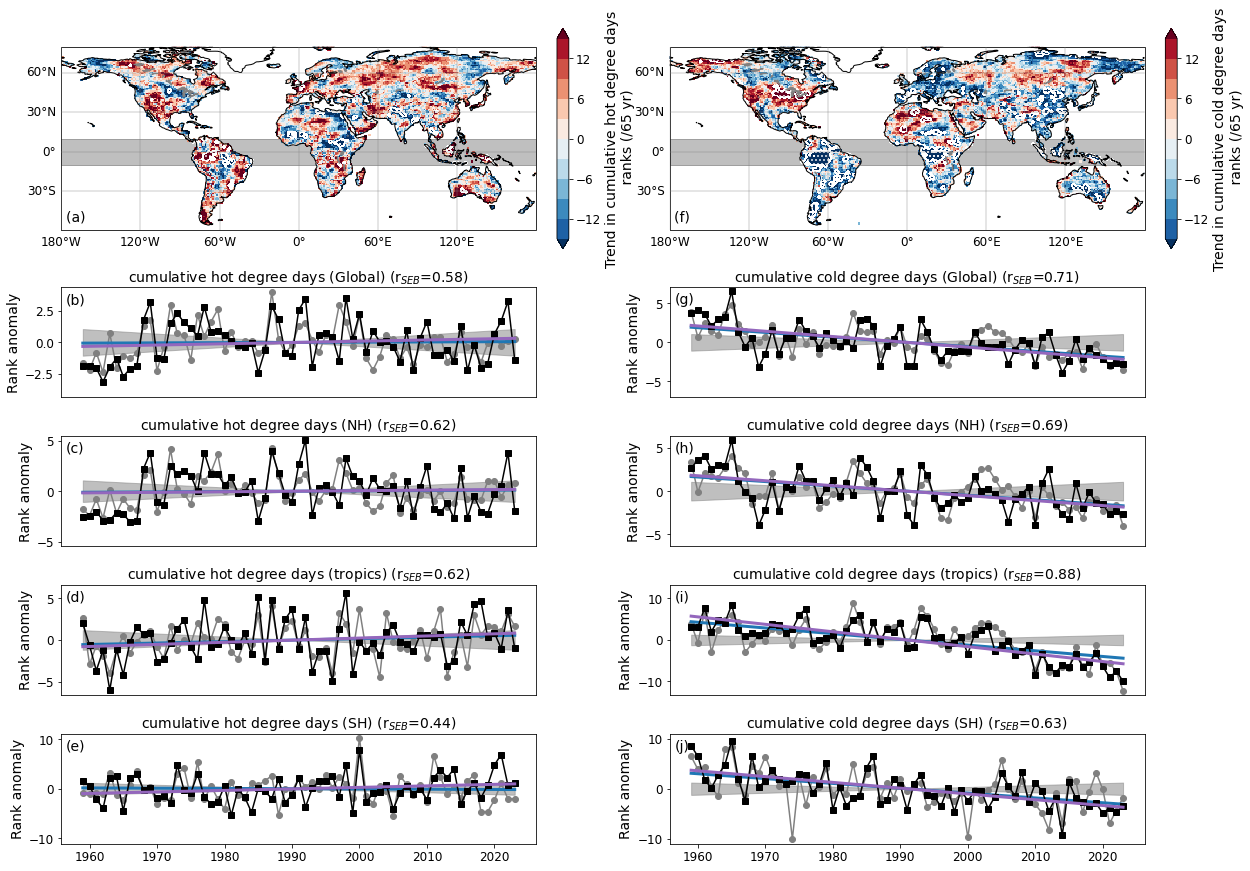

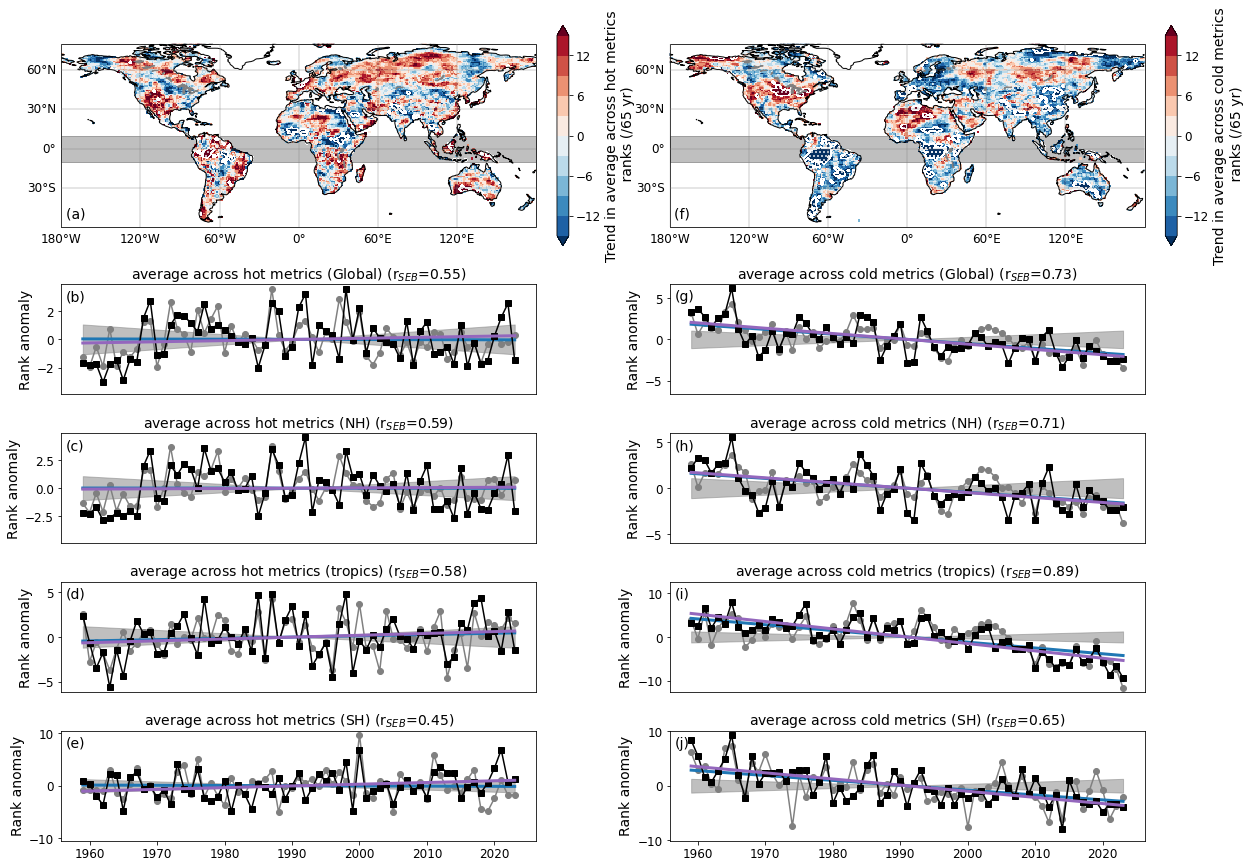

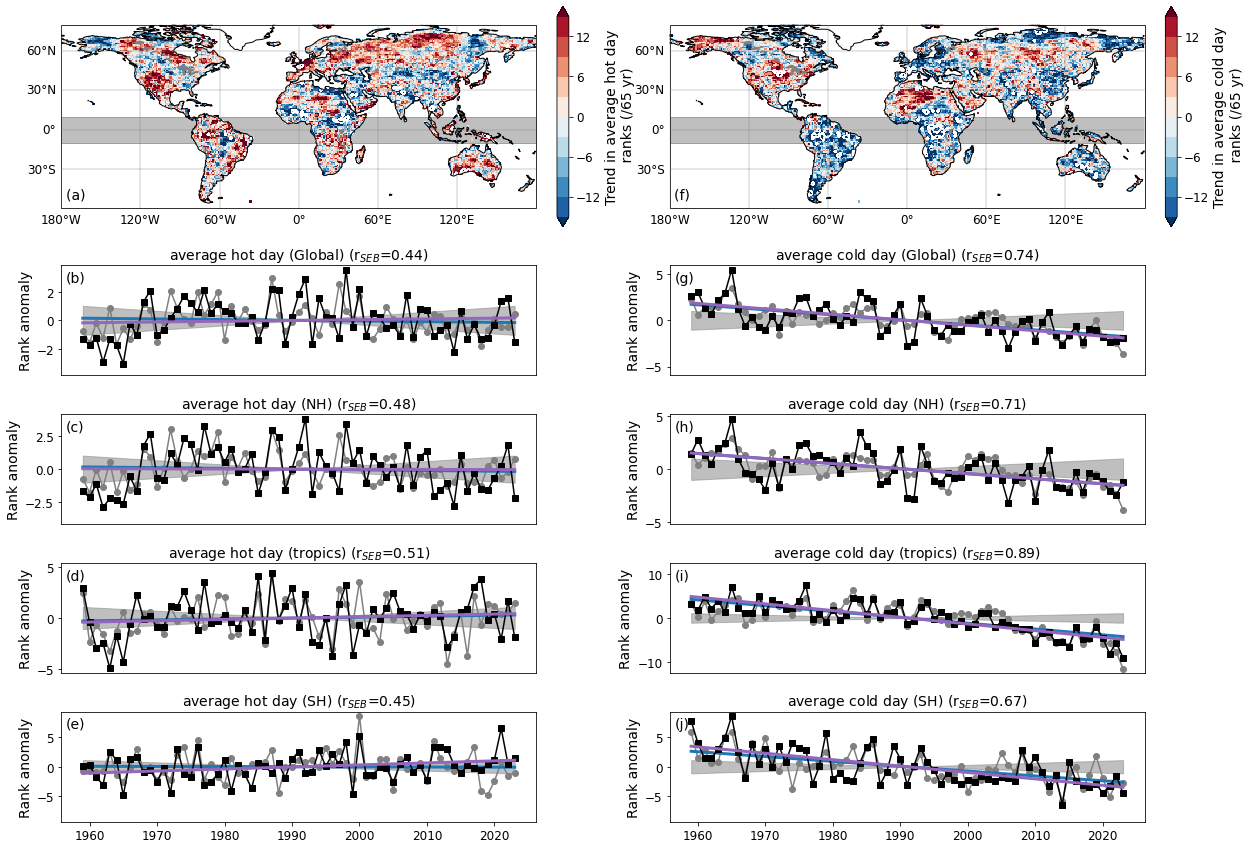

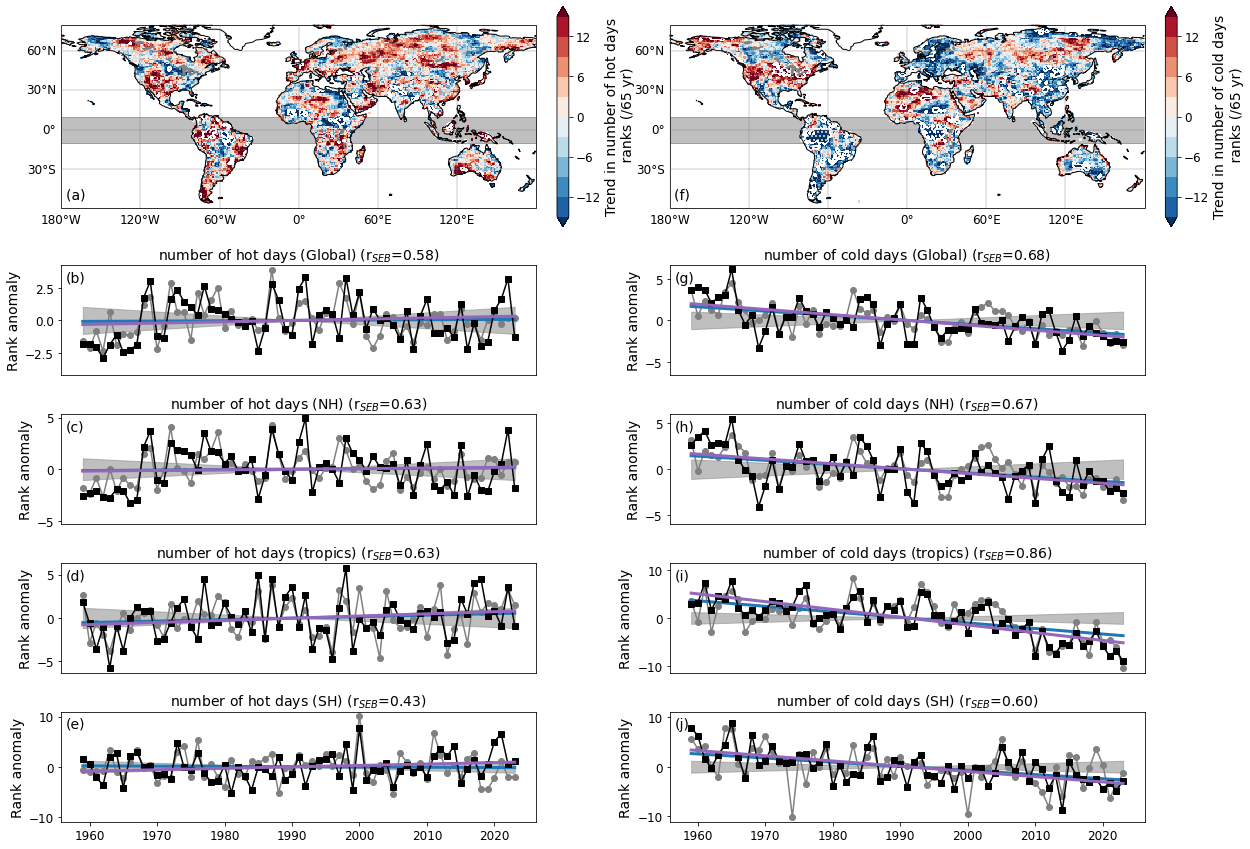

In [6]:
for plot_ct in range(4):
    if plot_ct == 0:
        this_metrics_to_plot = 'cum_excess_hot', 'cum_excess_cold'
        this_long_names = 'cumulative hot degree days', 'cumulative cold degree days'
    elif plot_ct == 2:
        this_metrics_to_plot = 'avg_excess_hot', 'avg_excess_cold'
        this_long_names = 'average hot day', 'average cold day'
    elif plot_ct == 3:
        this_metrics_to_plot = 'ndays_excess_hot', 'ndays_excess_cold'
        this_long_names = 'number of hot days', 'number of cold days'
    else:
        this_metrics_to_plot = 'avg_across_metrics_hot', 'avg_across_metrics_cold'
        this_long_names = 'average across hot metrics', 'average across cold metrics'
        
    figname = 'SUPP_fig01_%s.png' % this_metrics_to_plot[0].replace('_hot', '')
    make_rank_plots(ds_ranks_ERA5.copy(), 'ERA5', this_metrics_to_plot, this_long_names, figname, nsamples,
                    alpha_fdr, is_land, procdir, figdir,
                    ds_ranks2=ds_ranks_SEB.copy(), rank2name='SEB', make_map_rank2=False)

# Figure 1 over satellite era period

seasonal_max
0.0 percent of land has sig positive trend
0.0 percent of land has sig negative trend
Pearson correlation between trend maps: 0.23
seasonal_min
0.1 percent of land has sig positive trend
1.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.29
slope = -0.02, pval = 0.432, sig = False (Global seasonal_max)
slope = -0.03, pval = 0.191, sig = False (NH seasonal_max)
slope = -0.00, pval = 0.936, sig = False (tropics seasonal_max)
slope = 0.04, pval = 0.136, sig = False (SH seasonal_max)
slope = -0.05, pval = 0.060, sig = False (Global seasonal_min)
slope = -0.04, pval = 0.078, sig = False (NH seasonal_min)
slope = -0.18, pval = 0.000, sig = True (tropics seasonal_min)
slope = -0.06, pval = 0.038, sig = False (SH seasonal_min)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


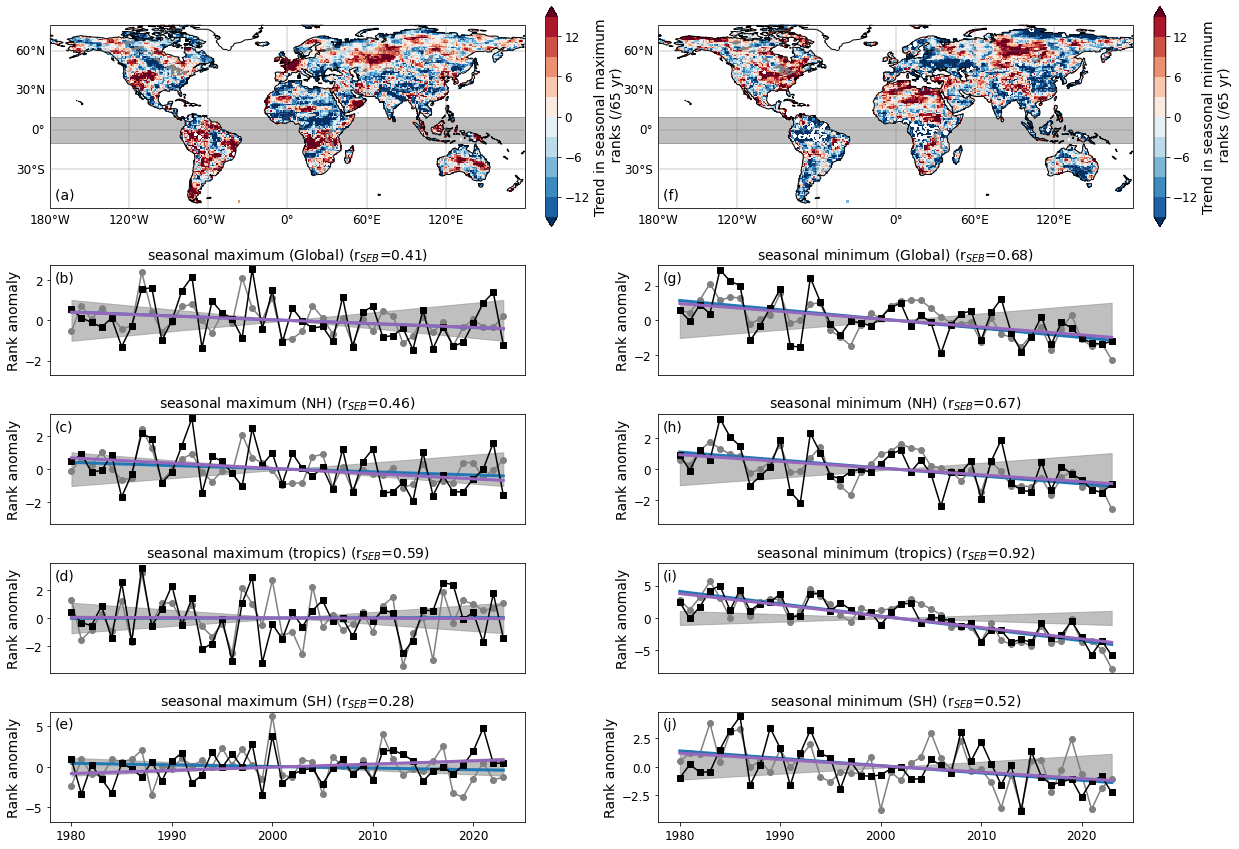

In [7]:
figname = 'SUPP_fig01_satera.png'

make_rank_plots(ds_ranks_ERA5_satera.copy(), 'ERA5_satera', metrics_to_plot, long_names, figname, nsamples,
                alpha_fdr, is_land, procdir, figdir,
                ds_ranks2=ds_ranks_SEB_satera.copy(), rank2name='SEB', make_map_rank2=False)

# Figure 1 with CHIRPS

seasonal_max
0.0 percent of land has sig positive trend
0.0 percent of land has sig negative trend
seasonal_max
0.0 percent of land has sig positive trend
0.0 percent of land has sig negative trend
Pearson correlation between trend maps: 0.81
seasonal_min
0.0 percent of land has sig positive trend
0.6 percent of land has sig negative trend
seasonal_min
0.0 percent of land has sig positive trend
0.3 percent of land has sig negative trend
Pearson correlation between trend maps: 0.88
slope = -0.01, pval = 0.729, sig = False (Global seasonal_max)
slope = -0.02, pval = 0.477, sig = False (NH seasonal_max)
slope = -0.01, pval = 0.730, sig = False (tropics seasonal_max)
slope = 0.04, pval = 0.237, sig = False (SH seasonal_max)
slope = -0.05, pval = 0.137, sig = False (Global seasonal_min)
slope = -0.04, pval = 0.187, sig = False (NH seasonal_min)
slope = -0.18, pval = 0.000, sig = True (tropics seasonal_min)
slope = -0.07, pval = 0.038, sig = False (SH seasonal_min)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


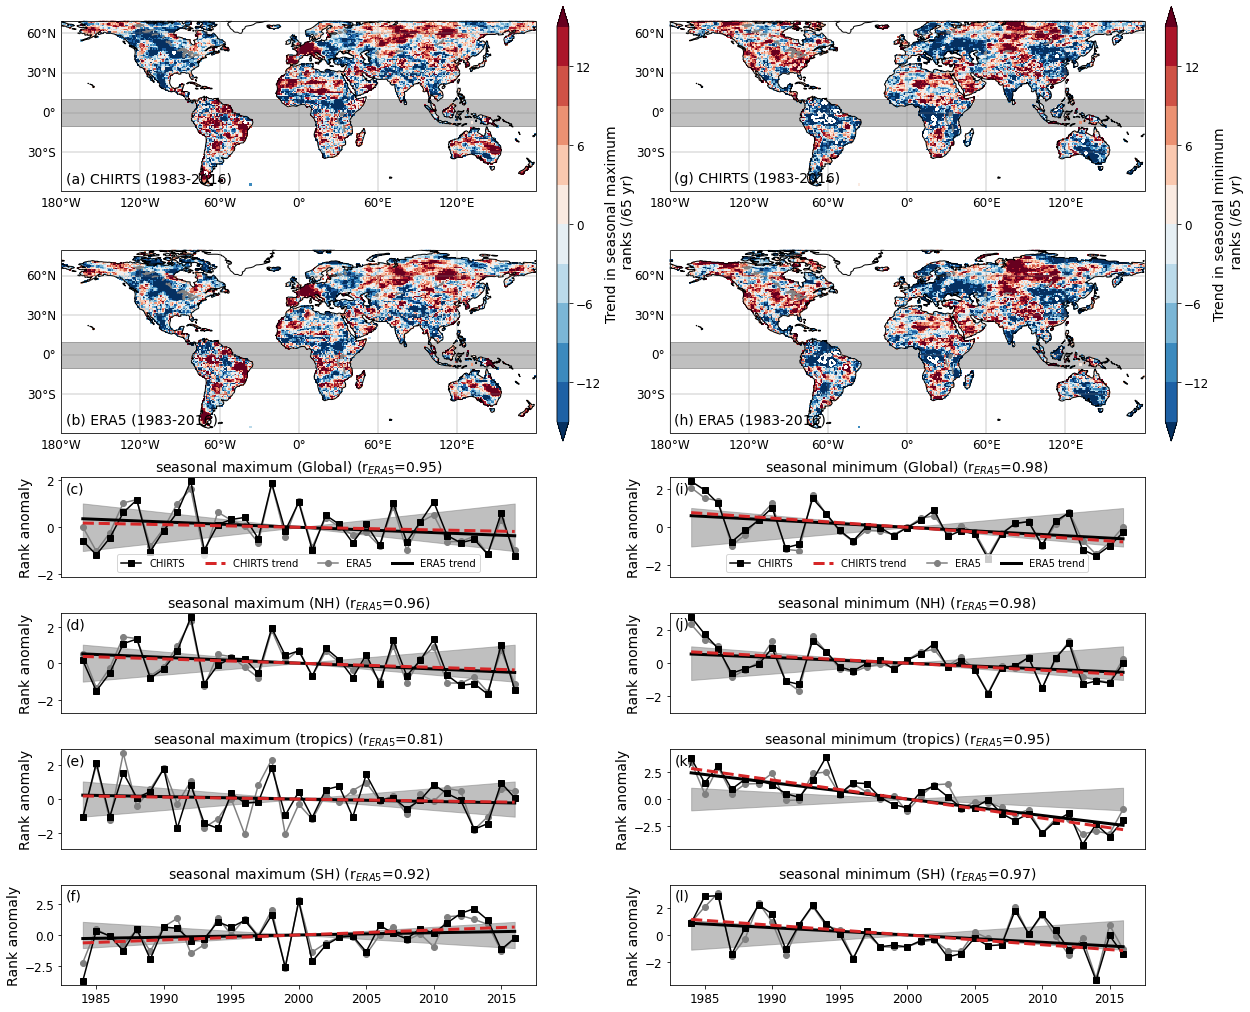

In [8]:
figname = 'SUPP_fig01_chirts.png'

make_rank_plots(ds_ranks_chirts.copy(), 'CHIRTS', metrics_to_plot, long_names, figname, nsamples,
                alpha_fdr, is_land, procdir, figdir,
                ds_ranks2=ds_ranks_ERA5_to_CHIRTS.copy(), 
                rank2name='ERA5', make_map_rank2=True,
                **{'label0': 'CHIRTS (1983-2016)', 
                   'label1': 'ERA5 (1983-2016)',
                   'legend_labels': list(('CHIRTS', 'CHIRTS trend', 'ERA5', 'ERA5 trend')),
                   'slope_colors': ('tab:red', 'k'),
                   'slope_ls': ('--', '-')})

# Figure 1 with a 5-year running median as baseline

seasonal_max
0.2 percent of land has sig positive trend
0.2 percent of land has sig negative trend
Pearson correlation between trend maps: 0.96
seasonal_min
0.4 percent of land has sig positive trend
3.6 percent of land has sig negative trend
Pearson correlation between trend maps: 0.98
slope = 0.01, pval = 0.738, sig = False (Global seasonal_max)
slope = -0.00, pval = 0.895, sig = False (NH seasonal_max)
slope = 0.01, pval = 0.450, sig = False (tropics seasonal_max)
slope = 0.04, pval = 0.035, sig = False (SH seasonal_max)
slope = -0.07, pval = 0.000, sig = True (Global seasonal_min)
slope = -0.06, pval = 0.001, sig = True (NH seasonal_min)
slope = -0.17, pval = 0.000, sig = True (tropics seasonal_min)
slope = -0.12, pval = 0.000, sig = True (SH seasonal_min)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


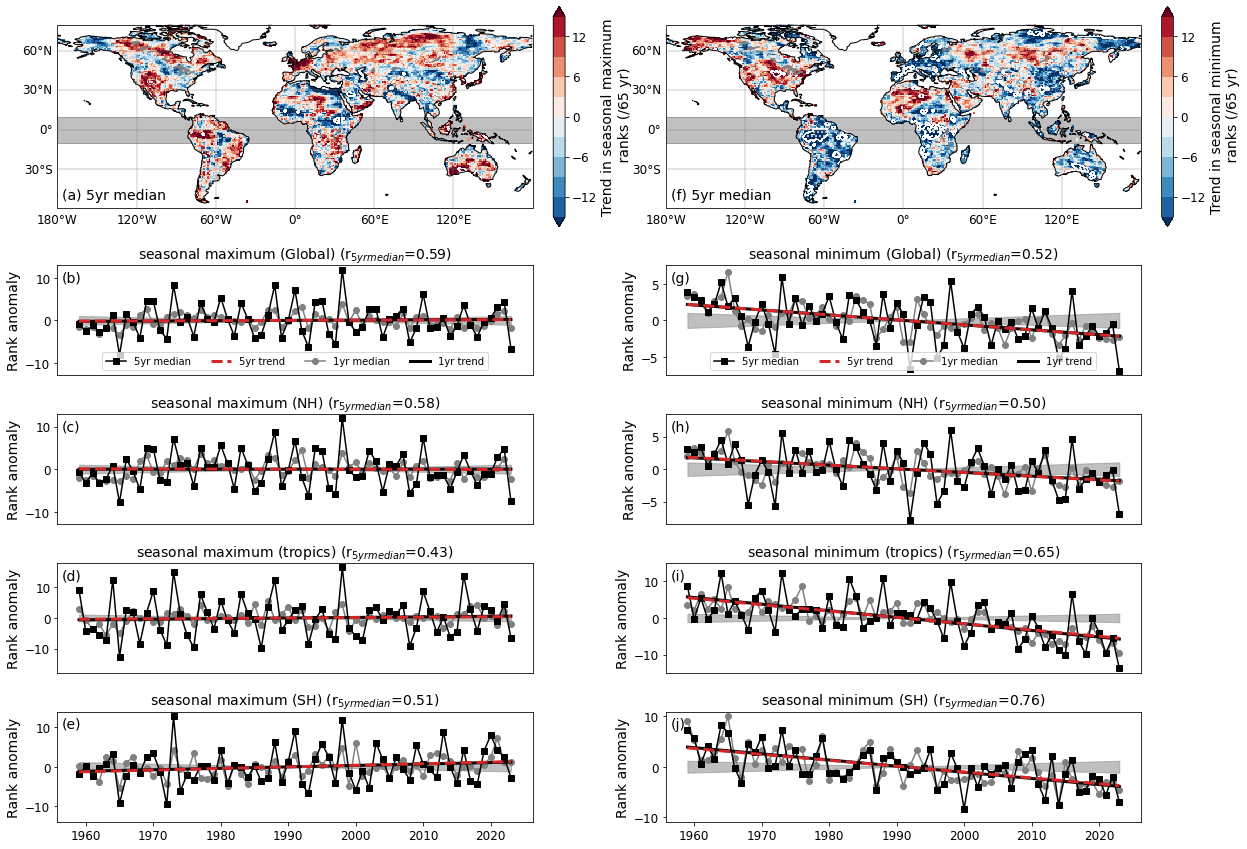

In [9]:
figname = 'SUPP_fig01_5yrmedian.png'

# In the below, the rank2name is used to label the correlation coefficient
# So, even though the first rank is using the 5-year median, the name is used for the label
make_rank_plots(ds_ranks_5yr.copy(), 'ERA5', metrics_to_plot, long_names, figname, nsamples,
                alpha_fdr, is_land, procdir, figdir,
                ds_ranks2=ds_ranks_ERA5.copy(), rank2name='5yr median', make_map_rank2=False,
                **{'label0': '5yr median', 
                   'legend_labels': list(('5yr median', '5yr trend', '1yr median', '1yr trend')),
                   'slope_colors': ('tab:red', 'k'),
                   'slope_ls': ('--', '-')})

# Figure 1, but with mean as baseline

seasonal_max
1.0 percent of land has sig positive trend
1.1 percent of land has sig negative trend
Pearson correlation between trend maps: 0.97
seasonal_min
0.6 percent of land has sig positive trend
3.7 percent of land has sig negative trend
Pearson correlation between trend maps: 0.98
slope = 0.02, pval = 0.275, sig = False (Global seasonal_max)
slope = 0.01, pval = 0.589, sig = False (NH seasonal_max)
slope = 0.05, pval = 0.008, sig = True (tropics seasonal_max)
slope = 0.06, pval = 0.002, sig = True (SH seasonal_max)
slope = -0.07, pval = 0.000, sig = True (Global seasonal_min)
slope = -0.05, pval = 0.001, sig = True (NH seasonal_min)
slope = -0.17, pval = 0.000, sig = True (tropics seasonal_min)
slope = -0.12, pval = 0.000, sig = True (SH seasonal_min)


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


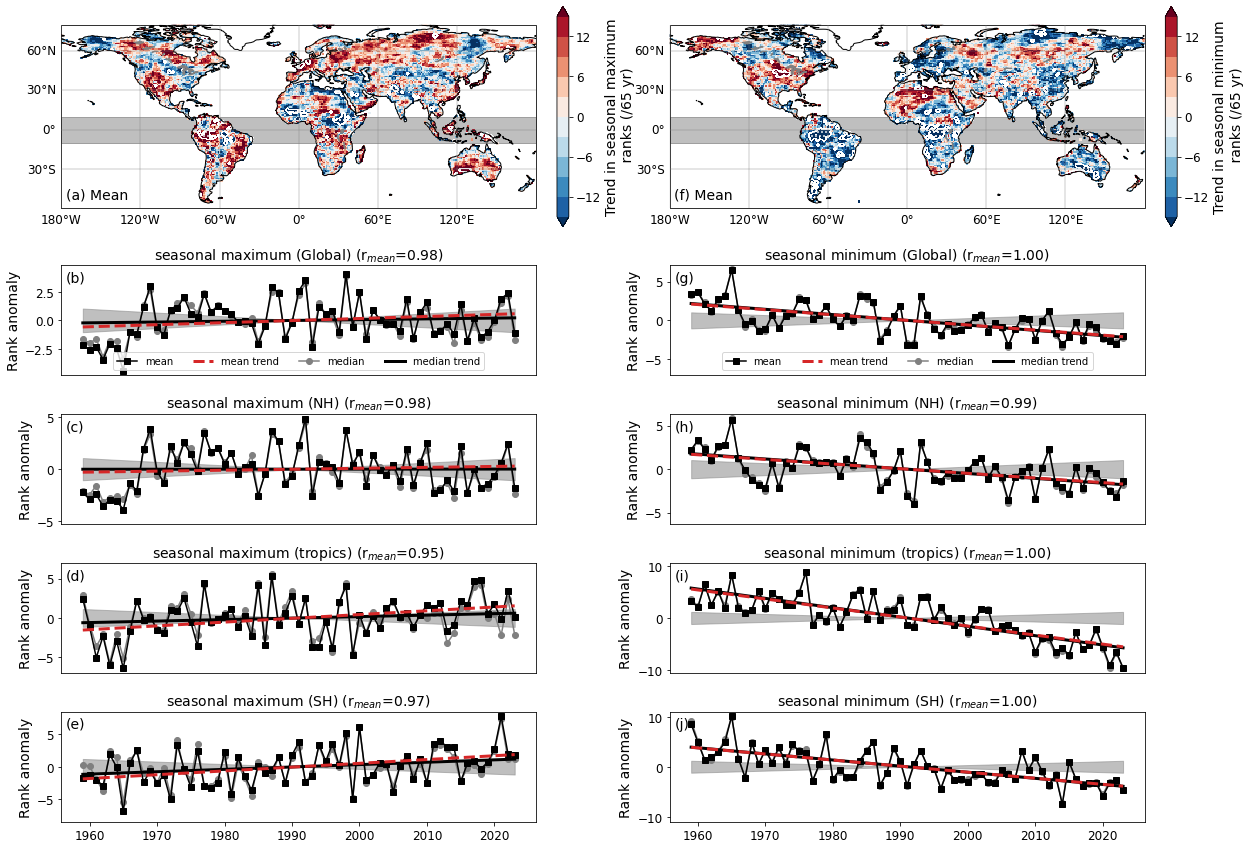

In [10]:
figname = 'SUPP_fig01_mean.png'

# In the below, the rank2name is used to label the correlation coefficient
# So, even though the first rank is using the 5-year median, the name is used for the label
make_rank_plots(ds_ranks_mean.copy(), 'ERA5', metrics_to_plot, long_names, figname, nsamples,
                alpha_fdr, is_land, procdir, figdir,
                ds_ranks2=ds_ranks_ERA5.copy(), rank2name='mean', make_map_rank2=False,
                **{'label0': 'Mean',
                   'legend_labels': list(('mean', 'mean trend', 'median', 'median trend')),
                   'slope_colors': ('tab:red', 'k'),
                   'slope_ls': ('--', '-')})

# Trend in ranks in GHCND and scatter plot with ERA5

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


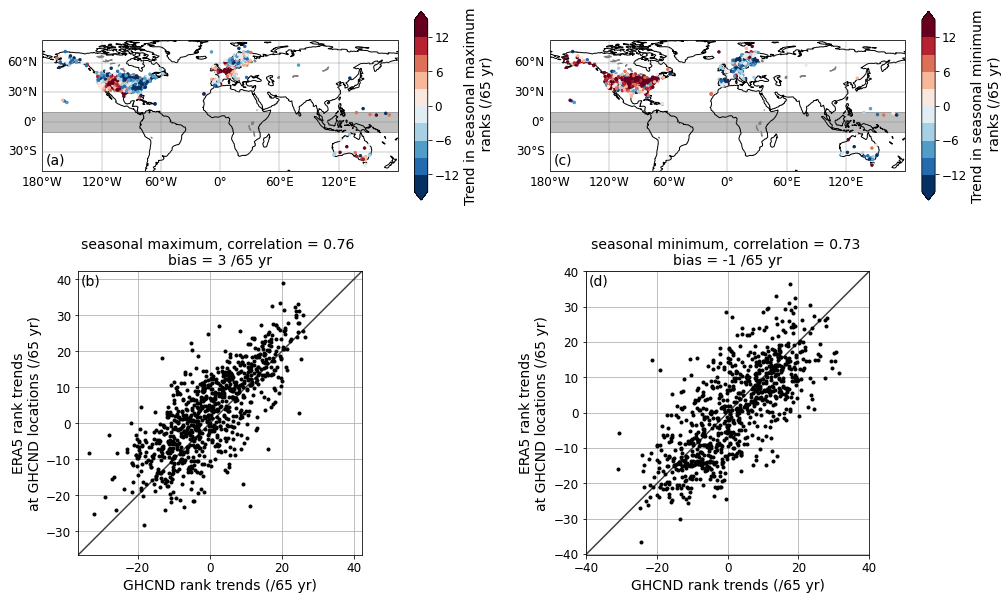

In [11]:
figname = 'SUPP_GHCND_vs_ERA5.png'
# First row is GHCND maps, and second row is scatter plot compared to ERA5

cmap = plt.cm.RdBu_r
bounds = np.arange(-15, 16, 3)

fig = plt.figure(figsize=(16, 10))
widths = [8, 0.3, 2, 8, 0.3]
heights = [2, 3]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.3)
letter_ct = 0

for ct_m, metric in enumerate(metrics_to_plot):
    col_ct = 3*ct_m
    cbar_label = 'Trend in %s\n ranks (/%i yr)' % (long_names[ct_m], trend_normalizer)
    
    # Shift longitude to match ERA5
    shifted_lon = ds_ranks_ghcnd.lon.data
    shifted_lon[shifted_lon < 0] += 360
    
    # Get trends in GHCND
    ghcnd_trends = get_trend_array(ds_ranks_ghcnd, metric, trend_normalizer=trend_normalizer)
    ghcnd_trends = ghcnd_trends.assign_coords({'lat': ds_ranks_ghcnd.lat,
                                               'lon': ds_ranks_ghcnd.lon})
    
    # Top row is map
    ax_map = fig.add_subplot(spec[0, col_ct], projection=plotcrs)
    ax_map, pc = make_standard_map(ghcnd_trends, ax_map, cmap, bounds, is_stations=True)
    
    ax_map.text(0.01, 0.05, '(%s)' % (letters[letter_ct]),
                transform=ax_map.transAxes, fontsize=fontsize)
    letter_ct += 1
    
    # Add colorbar
    cax = fig.add_subplot(spec[0, col_ct + 1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(cbar_label, fontsize=fontsize)

    # Get trends in ERA5 using same masking
    betas_masked = np.empty((len(ds_ranks_ghcnd.station)))
    for ct, (this_lat, this_lon) in enumerate(zip(ds_ranks_ghcnd.lat, ds_ranks_ghcnd.lon)):
        era5_ranks = ds_ranks_ERA5[metric].sel(lat=this_lat, lon=this_lon, method='nearest')
        ghcnd_ranks = ds_ranks_ghcnd[metric][:, ct]
        # mask ERA5 to ghcnd
        era5_ranks_masked = era5_ranks.where(~np.isnan(ghcnd_ranks))
        this_beta = era5_ranks_masked.polyfit(dim='year',  deg=1).sel(degree=1)['polyfit_coefficients']
        betas_masked[ct] = trend_normalizer*this_beta.data
        
    ax = fig.add_subplot(spec[1, col_ct])
    x = ghcnd_trends
    y = betas_masked

    pl = ~np.isnan(x) & ~np.isnan(y)
    x = x[pl]
    y = y[pl]

    ax.plot(x, y, '.k')

    # bias defined based on GHCND as baseline
    bias_val = (y - x).mean()
    # normalized bias in standard deviation units
    bias_norm = bias_val/x.std()

    rho = np.corrcoef(x, y)[0, 1]

    lower_count = np.sum(x > y)
    upper_count = np.sum(x < y)

    # ax.plot(x, y, '.k')
    # ax.hexbin(x, y, mincnt=1, gridsize=20)
    ax.grid()
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=5)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title('%s, correlation = %0.2f \nbias = %0.0f /%i yr' % (long_names[ct_m], 
                                                                    rho, bias_val, trend_normalizer), 
                 fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.text(0.01, 0.95, '(%s)' % (letters[letter_ct]), transform=ax.transAxes, fontsize=fontsize)
    letter_ct += 1
    ax.set_xlabel('GHCND rank trends (/%i yr)' % trend_normalizer, fontsize=fontsize)
    ax.set_ylabel('ERA5 rank trends\nat GHCND locations (/%i yr)' % trend_normalizer, fontsize=fontsize)

plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')


# Trends in SEB-predicted ranks, and map of correlations with actual ranks

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


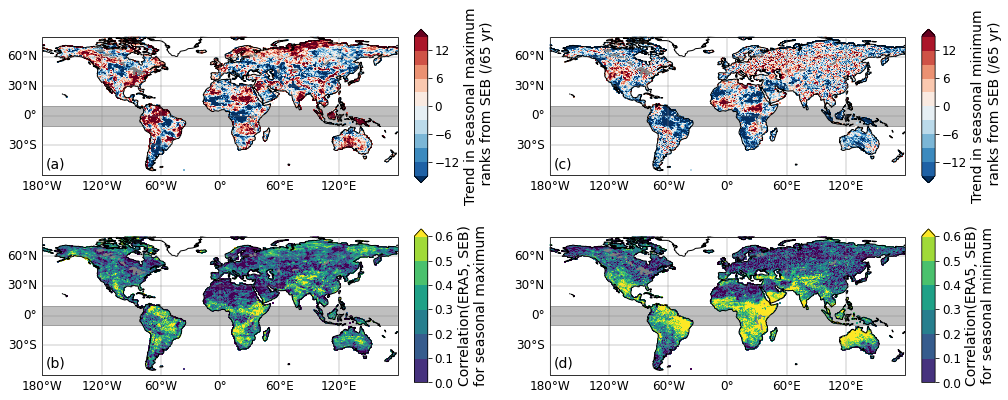

In [12]:
figname = 'SUPP_SEB_trend_maps.png'

cmap = plt.cm.RdBu_r
bounds = np.arange(-15, 16, 3)
cmap_corr = plt.cm.viridis
bounds_corr = np.arange(0, 0.61, 0.1)

fig = plt.figure(figsize=(16, 6.5))
widths = [8, 0.3, 2, 8, 0.3]
heights = [2, 2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.3)
letter_ct = 0

for ct_m, metric in enumerate(metrics_to_plot):
    col_ct = 3*ct_m
    cbar_label = 'Trend in %s\n ranks from SEB (/%i yr)' % (long_names[ct_m], trend_normalizer)
    
    rank_trends = get_trend_array(ds_ranks_SEB, metric, trend_normalizer=trend_normalizer)
    
    rho_ranks = xr.corr(ds_ranks_ERA5[metric], ds_ranks_SEB[metric], dim='year')
   
    # Top row is map
    ax_map = fig.add_subplot(spec[0, col_ct], projection=plotcrs)
    ax_map, pc = make_standard_map(rank_trends, ax_map, cmap, bounds)
    ax_map.text(0.01, 0.05, '(%s)' % (letters[letter_ct]),
                transform=ax_map.transAxes, fontsize=fontsize)
    letter_ct += 1
    
    # Add colorbar
    cax = fig.add_subplot(spec[0, col_ct + 1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(cbar_label, fontsize=fontsize)
    
    # Add correlation plot
    ax_map = fig.add_subplot(spec[1, col_ct], projection=plotcrs)
    ax_map, pc = make_standard_map(rho_ranks, ax_map, cmap_corr, bounds_corr)
    ax_map.text(0.01, 0.05, '(%s)' % (letters[letter_ct]),
                transform=ax_map.transAxes, fontsize=fontsize)
    letter_ct += 1
    
    # Add colorbar
    cax = fig.add_subplot(spec[1, col_ct + 1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='max')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label('Correlation(ERA5, SEB)\nfor %s' % long_names[ct_m], fontsize=fontsize)

plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')


# Aerosol time series comparison

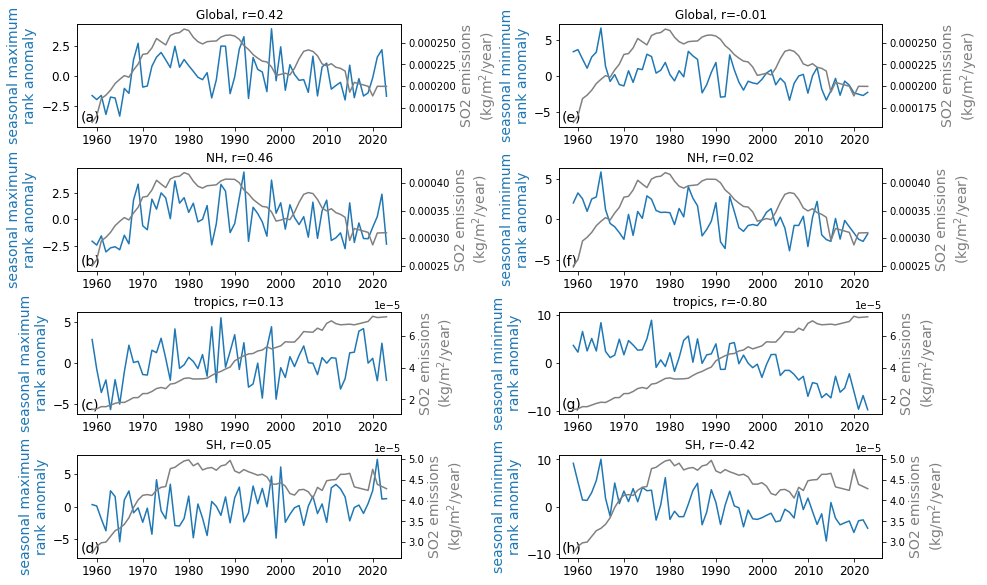

In [13]:
figname = 'SUPP_aerosols.png'

# Load SO2 from input4MIP (all sources)
forcing_dir = '/home/data/CMIP6/input4MIP'
files = sorted(glob('%s/SO2-em-anthro_input4MIPs_emissions*' % forcing_dir))
ds = xr.open_mfdataset(files)
# load through 2025 because SSPs are only every 5 years
so2 = ds['SO2_em_anthro'].sum('sector').sel(time=slice('%04i' % (hist_year1 + 1), '2030')).load() 

# Fix time
new_time = [datetime.date(yy, mm, 15) for yy, mm in zip(so2.time.dt.year.data, so2.time.dt.month.data)]
so2['time'] = pd.DatetimeIndex(new_time)
full_time = pd.date_range(start=new_time[0], end=new_time[-1], freq='M')
so2 = so2.interp({'time': full_time})
so2 = so2.sel(time=slice('%04i' % hist_year2))

# Get annual mean (units: kg m-2 s-1)
so2_forcing = so2.groupby('time.year').mean()

# Convert to emissions per year to get nicer numbers
sec_per_year = 60*60*24*365
so2_forcing *= sec_per_year
so2_forcing = so2_forcing.assign_attrs({'units': 'kg m-2 yr-1'})

del ds, so2

# Get regional averages for SO2
so2_regional = calc_regional_averages(so2_forcing, regions)
avg_rank = (len(ds_ranks_ERA5.year) + 1)/2

# Make figure
fig, axes = plt.subplots(figsize=(12, 8), nrows=4, ncols=2)
fig.tight_layout(w_pad=12, h_pad=2)
metrics = 'seasonal_max', 'seasonal_min'
letter_ct = 0
for m_ct, metric in enumerate(metrics_to_plot):
    metric_regional = calc_regional_averages(ds_ranks_ERA5[metric], regions)
    for r_ct, region in enumerate(regions):

        ax = axes[r_ct, m_ct]
        
        (metric_regional.sel(region=region) - avg_rank).plot(ax=ax)
        ax2 = ax.twinx()
        
        so2_regional.sel(region=region).plot(ax=ax2, color='gray')
        #ax2.invert_yaxis()
        rho = xr.corr(metric_regional.sel(region=region), so2_regional.sel(region=region))
        
        ax.set_title('%s, r=%0.2f' % (region, rho))
        ax.tick_params(labelsize=labelsize)
        ax.set_xlabel('')
        yabs_max = abs(max(ax.get_ylim(), key=abs))
        ax.set_ylim(ymin=-yabs_max, ymax=yabs_max)
        ax2.set_xlabel('')
        ax2.set_title('')
        ax.set_ylabel('%s\nrank anomaly' % long_names[m_ct], fontsize=fontsize, color='tab:blue')
        ax2.set_ylabel('SO2 emissions\n(kg/m$^2$/year)', fontsize=fontsize, color='gray')
        ax.text(0.01, 0.05, '(%s)' % letters[letter_ct], transform=ax.transAxes, fontsize=fontsize)
        letter_ct += 1
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Climatology and trends of day of season of extremes

corr trends in doy and ranks: -0.06
corr trends in doy and ranks: 0.05


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


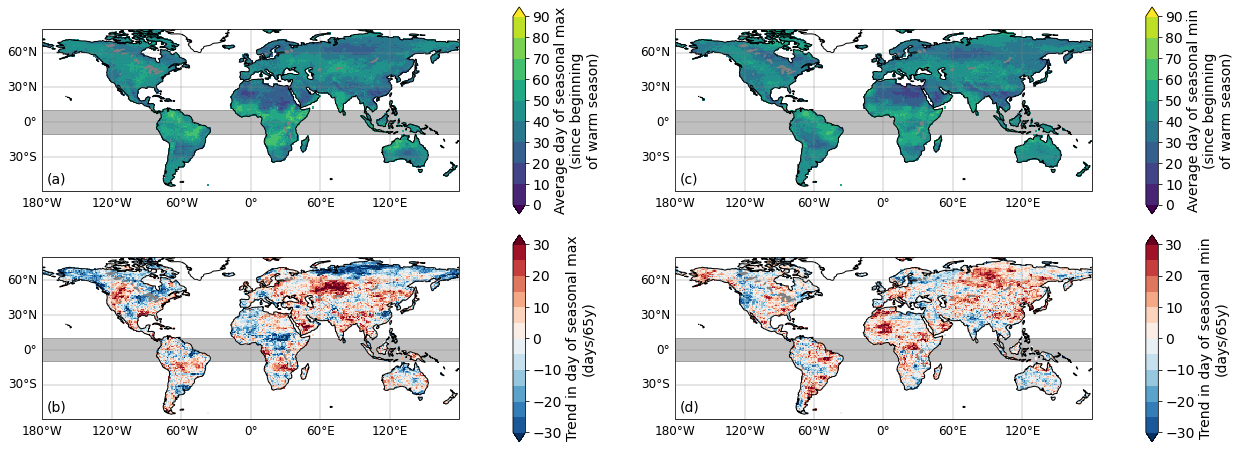

In [14]:
figname = 'SUPP_day_of_extremes.png'
cold_doy_relative = xr.open_dataarray('%s/cold_doy_relative.nc' % procdir)
hot_doy_relative = xr.open_dataarray('%s/hot_doy_relative.nc' % procdir)

# plot mean state of day of year on top, trend on bottom
# hot on left, cold on right
fig = plt.figure(figsize=(20, 8))
widths = [10, 0.3, 1, 10, 0.3]

spec = fig.add_gridspec(ncols=len(widths), nrows=2, width_ratios=widths)

spec.update(wspace=0.3, hspace=0.1)

letter_count = 0
for data_ct in range(2):
    
    if data_ct == 0:
        base_data = hot_doy_relative.copy()
        name = 'max'
    else:
        base_data = cold_doy_relative.copy()
        name = 'min'
        
    rank_trends = get_trend_array(ds_ranks_ERA5, 'seasonal_%s' % name, trend_normalizer)
    
    
    for ct_type in range(2):
        
        if ct_type == 0:
            to_plot = base_data.mean('year')
            bounds = np.arange(0, 91, 10)
            cmap = plt.cm.viridis
            label = 'Average day of seasonal %s\n(since beginning\nof warm season)' % name
        else:
            to_plot = base_data.polyfit(dim='year', deg=1)
            to_plot = trend_normalizer*(to_plot['polyfit_coefficients'].sel(degree=1))
            bounds = np.arange(-30, 31, 5)
            cmap = plt.cm.RdBu_r
            label = 'Trend in day of seasonal %s\n(days/%iy)' % (name, trend_normalizer)
            
            rho = xr.corr(to_plot, rank_trends)
            print('corr trends in doy and ranks: %0.2f' % rho)
                

        ax_map = fig.add_subplot(spec[ct_type, data_ct*3], projection=plotcrs)
        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds)

        cax = fig.add_subplot(spec[ct_type, data_ct*3 + 1])
        cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
        cb.set_label(label, fontsize=fontsize)
        cb.ax.tick_params(labelsize=14) 
        
        ax_map.text(0.01, 0.05, '(%s)' % (letters[letter_count]), 
                    transform=ax_map.transAxes,
                    fontsize=fontsize)
        letter_count += 1
        
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')


# Figure 2 using only 1980-present data, and average across precipitation datasets, and T1a and T1b separately

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Correlation, hot tail, T1 vs T1a: 0.82
Correlation, hot tail, T1 vs T1b: -0.22
Correlation, hot tail, T1 vs T2: 0.04
Correlation, hot tail, T1 vs total: 0.52
Correlation, hot tail, T1 vs precip: -0.16
Correlation, hot tail, T1a vs T1b: -0.74
Correlation, hot tail, T1a vs T2: 0.21
Correlation, hot tail, T1a vs total: 0.57
Correlation, hot tail, T1a vs precip: -0.25
Correlation, hot tail, T1b vs T2: -0.31
Correlation, hot tail, T1b vs total: -0.37
Correlation, hot tail, T1b vs precip: 0.25
Correlation, hot tail, T2 vs total: 0.87
Correlation, hot tail, T2 vs precip: -0.13
Correlation, hot tail, total vs precip: -0.19
Correlation, cold tail, T1 vs T1a: 0.90
Correlation, cold tail, T1 vs T1b: -0.43
Correlation, cold tail, T1 vs T2: 0.48
Correlation, cold tail, T1 vs total: 0.75
Correlation, cold tail, T1 vs precip: -0.35
Correlation, cold tail, T1a vs T1b: -0.78
Correlation, cold tail, T1a vs T2: 0.50
Correlation, cold tail, T1a vs total: 0.73
Correlation, cold tail, T1a vs precip: -0.36
C

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


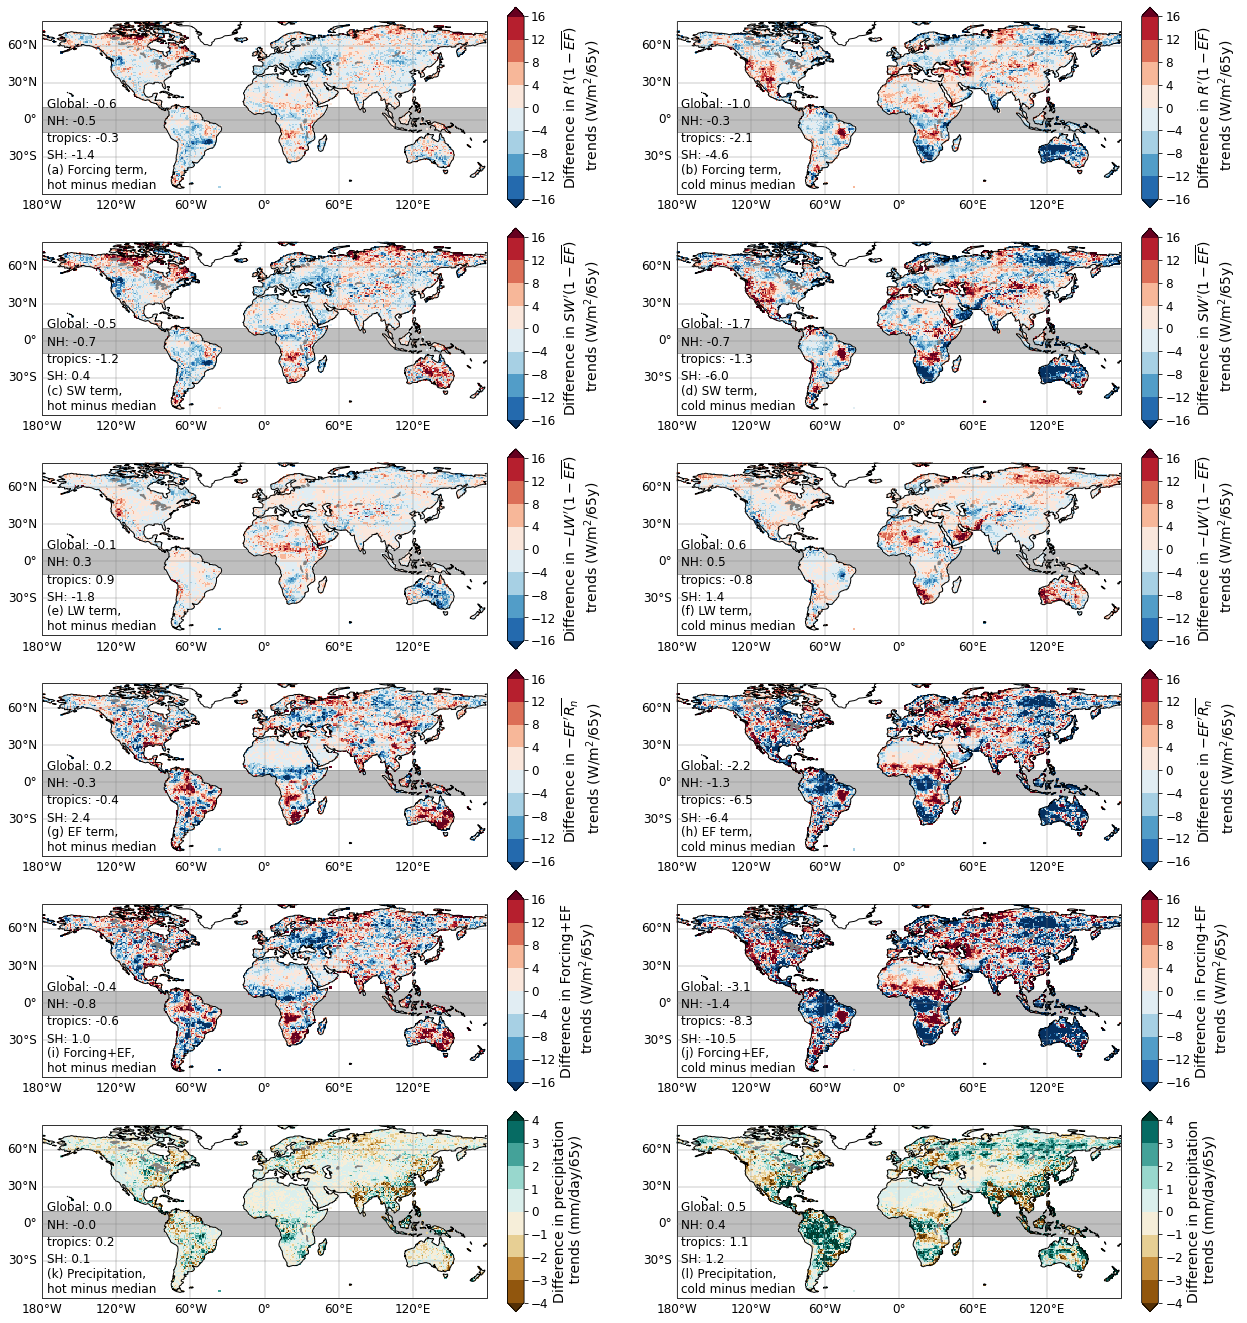

In [15]:
figname = 'SUPP_fig02_satera.png'
terms = 'T1', 'T1a', 'T1b', 'T2', 'total', 'precip'

# Which year to start the SEB analysis?
SEB_start_year = sat_year1

f_SEB = '%s/SEB_relative_trends_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                       SEB_start_year, hist_year2)
SEB_rel_trends = xr.open_dataset(f_SEB)

# For precipitation, use average across many datasets
pr_datasources = 'ERA5', 'CHIRPS', 'CPC', 'GPCC', 'PERSIANN', 'MSWEP'
precip_rel_trends = combine_pr_datasets(pr_datasources, procdir, percentile_width, sat_year1, tail_dict)

make_SEB_plots(SEB_rel_trends, precip_rel_trends, terms, tail_dict, figname, figdir)
compare_maps(SEB_rel_trends, precip_rel_trends, terms, tail_dict)

# T1a and T1b for Figure 2

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Correlation, hot tail, T1a vs T1b: -0.72
Correlation, cold tail, T1a vs T1b: -0.74


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


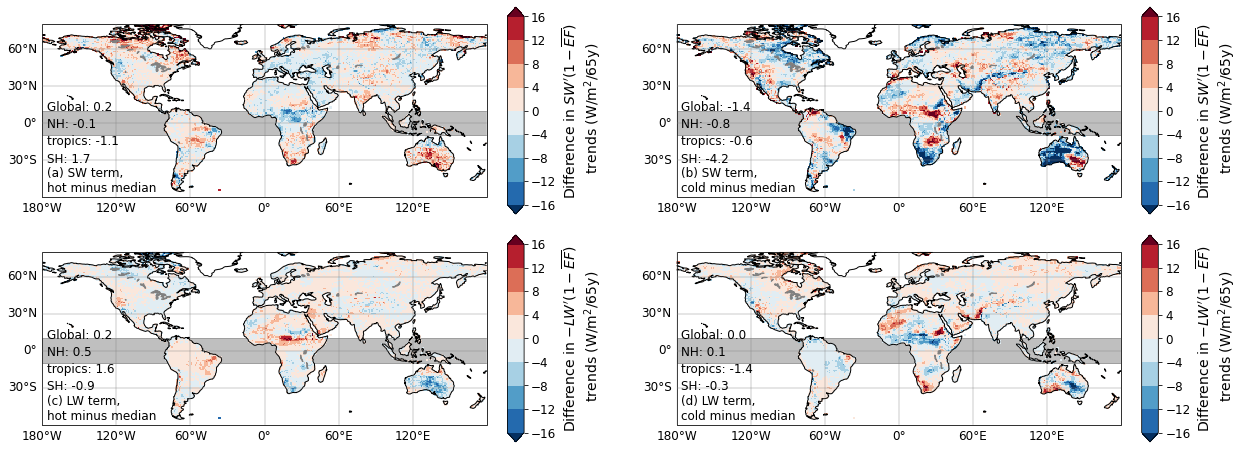

In [16]:
figname = 'SUPP_fig02_T1ab.png'
terms = 'T1a', 'T1b'

# Which year to start the SEB analysis?
SEB_start_year = hist_year1

f_SEB = '%s/SEB_relative_trends_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                       SEB_start_year, hist_year2)

SEB_rel_trends = xr.open_dataset(f_SEB)

if SEB_start_year == sat_year1:
    # For precipitation, use average across many datasets
    pr_datasources = 'ERA5', 'CHIRPS', 'CPC', 'GPCC', 'PERSIANN', 'MSWEP'
    precip_rel_trends = combine_pr_datasets(pr_datasources, procdir, percentile_width, sat_year1, tail_dict)
elif SEB_start_year == hist_year1: 
    # Use only ERA5
    f_precip = '%s/ERA5_precip_relative_stats_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                                     SEB_start_year, hist_year2)
    precip_rel_trends = xr.open_dataset(f_precip)

make_SEB_plots(SEB_rel_trends, precip_rel_trends, terms, tail_dict, figname, figdir)
compare_maps(SEB_rel_trends, precip_rel_trends, terms, tail_dict)

# Precipitation stats in each dataset: trends, probability, average precipitation

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


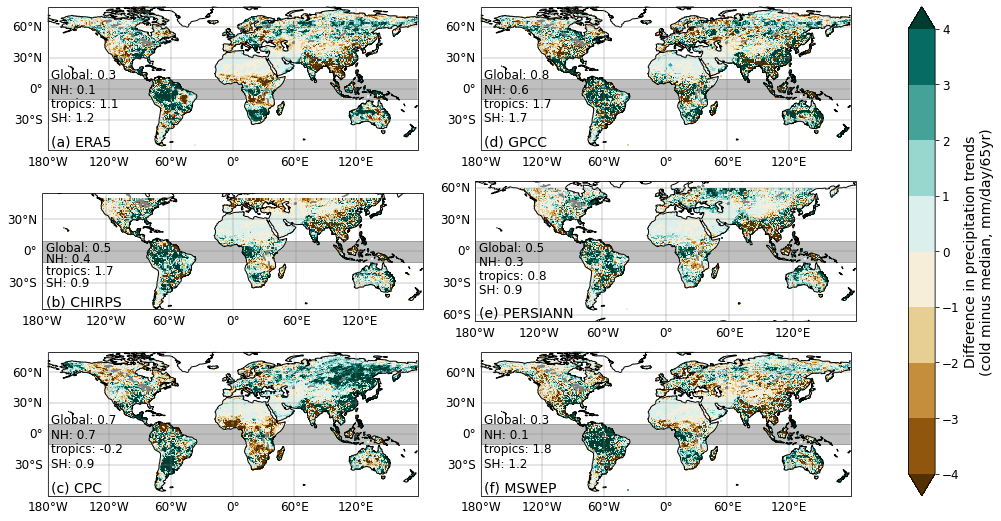

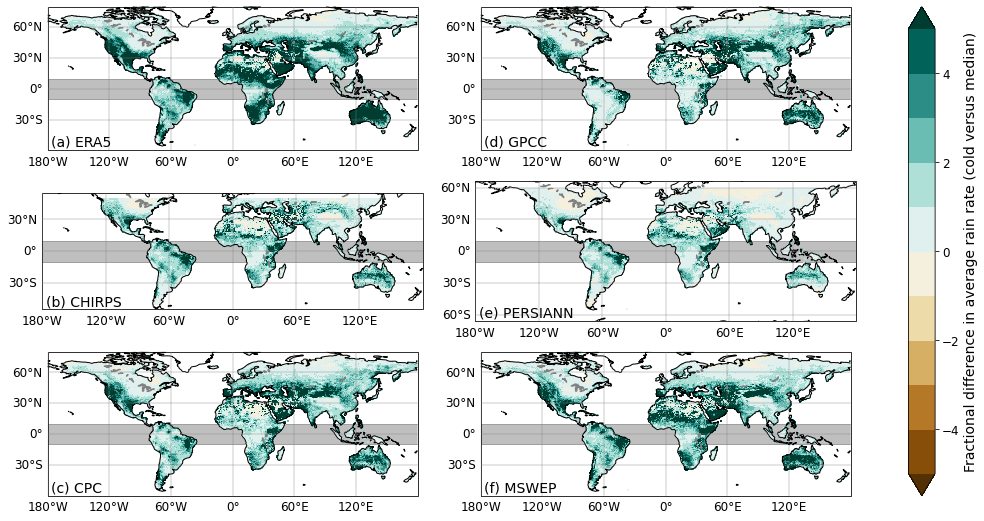

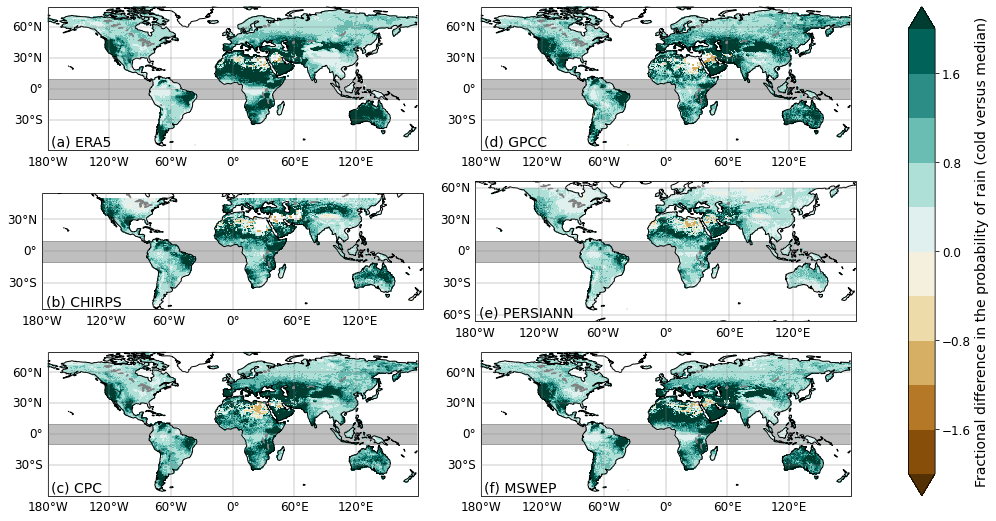

In [17]:
pr_datasources = 'ERA5', 'CHIRPS', 'CPC', 'GPCC', 'PERSIANN', 'MSWEP'
pr_start_year = 1979
stat_opts = 'trend', 'avg_rain', 'prob_rain'

for s in stat_opts:
    
    if s == 'trend':
        cbar_label = 'Difference in precipitation trends\n(cold minus median, mm/day/%iyr)' % trend_normalizer
        bounds = np.arange(-4, 5, 1)

    elif s == 'avg_rain':
        cbar_label = 'Fractional difference in average rain rate (cold versus median)'
        bounds = 5*np.arange(-1, 1.1, 0.2)
      
    elif s == 'prob_rain':
        cbar_label = 'Fractional difference in the probability of rain (cold versus median)'
        bounds = 2*np.arange(-1, 1.1, 0.2)
   

    fig = plt.figure(figsize=(16, 3*len(pr_datasources)/2))

    widths = [1, 1, 0.07]
    heights = 2*np.ones(int(len(pr_datasources)/2))
    spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

    spec.update(wspace=0.2, hspace=0.2)

    cmap = plt.cm.BrBG
    letter_ct = 0

    for ct_d, datasource in enumerate(pr_datasources):

        col_ct = int(np.floor(ct_d / 3))
        row_ct = ct_d % 3

        fname = '%s/%s_precip_relative_stats_p%02i_%04i-2023.nc' % (procdir, datasource,
                                                                    percentile_width, pr_start_year)
        these_trends = xr.open_dataset(fname)
        if s == 'trend':
            to_plot = (these_trends['%s_p%02i' % (s, tail_dict['cold'])] - 
                       these_trends['%s_p%02i' % (s, tail_dict['median'])])
        else:  # use fractional change
            to_plot = (these_trends['%s_p%02i' % (s, tail_dict['cold'])] - 
                       these_trends['%s_p%02i' % (s, tail_dict['median'])])
            to_plot /= these_trends['%s_p%02i' % (s, tail_dict['median'])]

        ax_map = fig.add_subplot(spec[row_ct, col_ct], projection=plotcrs)

        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds)
        ax_map.set_title('')
        ax_map.text(0.01, 0.03, '(%s) %s' % (letters[letter_ct], datasource), 
                    transform=ax_map.transAxes, fontsize=fontsize)

        letter_ct += 1

        # Get average values for each region to put on map
        if s == 'trend':
            ax_map = add_text_regional_averages(to_plot, ax_map, regions)


    cax = fig.add_subplot(spec[:, -1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=labelsize) 
    cb.set_label(cbar_label, fontsize=fontsize)

    plt.savefig('%s/SUPP_fig_precip_%s_multidata.png' % (figdir, s), dpi=200, bbox_inches='tight')

# Relative precipitation trends compared to GHCND

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


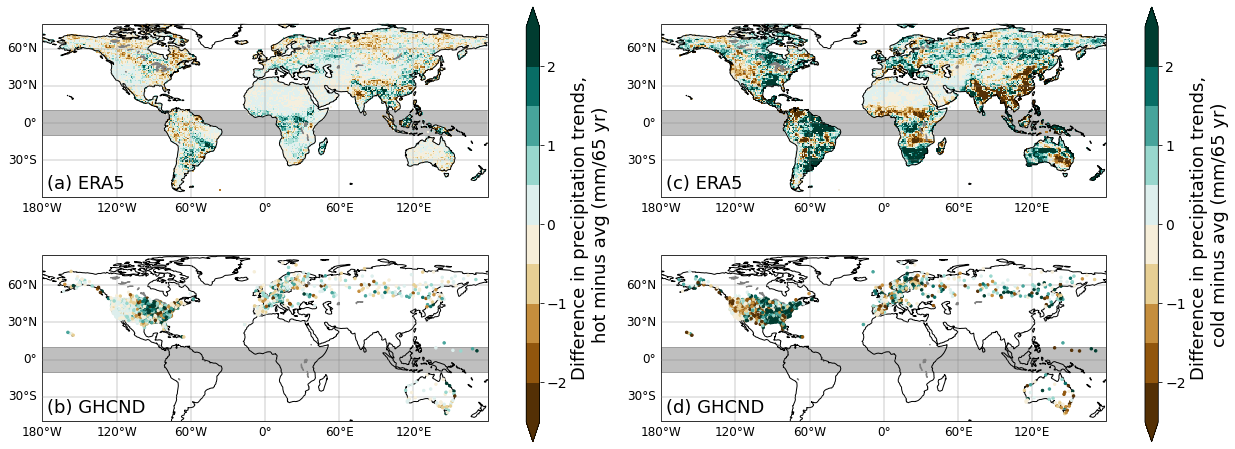

In [18]:
fname_ERA5 = '%s/ERA5_precip_relative_stats_p%02i_1958-2023.nc' % (procdir, percentile_width)
fname_GHCND = fname_ERA5.replace('ERA5', 'GHCND')
ds_relative_trends_precip_ERA5 = xr.open_dataset(fname_ERA5)
ds_relative_trends_precip_GHCND = xr.open_dataset(fname_GHCND)

# also need to open GHCND data just to get lats/lons
tmp = xr.open_dataarray('%s/smoothed_seasonal_cycles_GHCND.nc' % procdir)
GHCND_lat = tmp.lat
GHCND_lon = tmp.lon
assert len(GHCND_lat) == len(ds_relative_trends_precip_GHCND.station)
tails = 'hot', 'cold'

# plot ERA5 on top (like in Fig 2), GHCND on bottom
fig = plt.figure(figsize=(20, 8))
widths = [10, 0.3, 1, 10, 0.3]

spec = fig.add_gridspec(ncols=len(widths), nrows=2, width_ratios=widths)

spec.update(wspace=0.2, hspace=0.1)
cmap = plt.cm.BrBG
bounds = np.arange(-10, 11, 2)/4
letter_count = 0

for ct, tail in enumerate(tails):
    for data_ct in range(2):
        if data_ct == 0:
            to_plot = (ds_relative_trends_precip_ERA5['trend_p%02i' % tail_dict[tail]] - 
                       ds_relative_trends_precip_ERA5['trend_p50'])
            name = 'ERA5'
            is_stations = False
        else:
            to_plot = (ds_relative_trends_precip_GHCND['trend_p%02i' % tail_dict[tail]] - 
                       ds_relative_trends_precip_GHCND['trend_p50'])
            name = 'GHCND'
            is_stations = True

        ax_map = fig.add_subplot(spec[data_ct, ct*3], projection=plotcrs)
        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds, is_stations=is_stations)

        ax_map.set_title('')        
        ax_map.text(0.01, 0.05, '(%s) %s' % (letters[letter_count], name), 
                    transform=ax_map.transAxes,
                    fontsize=18)
        letter_count += 1
    cax = fig.add_subplot(spec[:, ct*3 + 1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=14) 
    cb.set_label('Difference in precipitation trends, \n%s minus avg (mm/65 yr)' % (tail), 
                     fontsize=18)
        
plt.savefig('%s/SUPP_ERA5_vs_GHCND_trends_maps_precip.png' % (figdir), dpi=200, bbox_inches='tight')

# Trends in precipitation on each type of day in ERA5

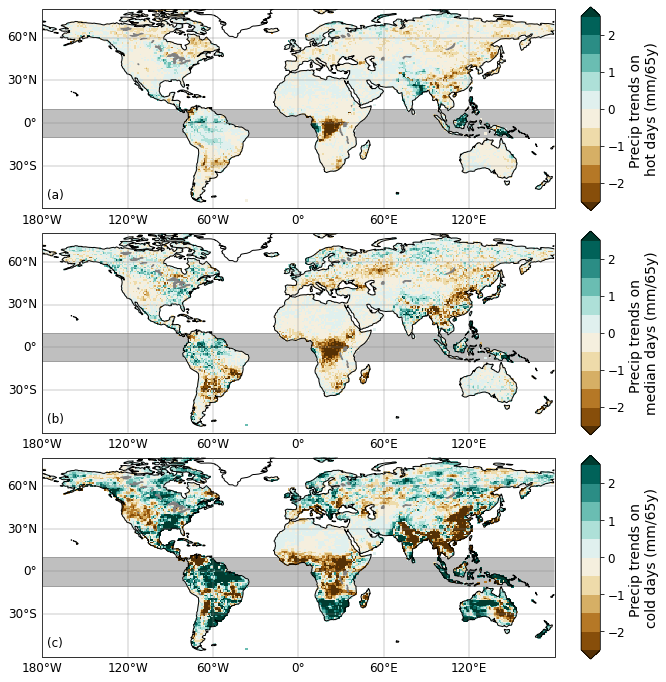

In [19]:
fig = plt.figure(figsize=(10, 12))
widths = [8, 0.3]
heights = [2, 2, 2]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

f_precip = '%s/ERA5_precip_relative_stats_p%02i_1958-2023.nc' % (procdir, percentile_width)
ds_relative_trends_precip = xr.open_dataset(f_precip)
tbins = 'hot', 'median', 'cold'
for ct, tbin in enumerate(tbins):

    to_plot = ds_relative_trends_precip['trend_p%02i' % (tail_dict[tbin])]

    bounds = np.arange(-10, 11, 2)/4
    units = 'mm'
    cmap = plt.cm.BrBG

    cbar_label = 'Precip trends on \n%s days (%s/%iy)' % (tbin, units, trend_normalizer)

    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax_map = fig.add_subplot(spec[ct, 0], projection=plotcrs)
    ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds)


    cax = fig.add_subplot(spec[ct, 1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=labelsize) 
    cb.set_label(cbar_label, fontsize=fontsize)

    ax_map.set_title('')
    ax_map.text(0.01, 0.05, '(%s)' % (letters[ct]), 
                transform=ax_map.transAxes, fontsize=12)

plt.savefig('%s/SUPP_ERA5_precip_trends.png' % figdir, dpi=200, bbox_inches='tight')

# Scatter across CMIP6 of relative precipitation trends and rank trends

In [20]:
scenario = 'hist'
metric = 'seasonal_min'
tail = 'cold'
stat = 'trend'

# Get trends in ranks
ds_ranks_cmip = cmip_avg_vals_hist_ssp.sel(scenario='hist')
ds_ranks_cmip = ds_ranks_cmip.dropna(dim='model-variant', how='all')
ds_ranks_cmip = ds_ranks_cmip.dropna(dim='year', how='all')

beta_ranks_cmip = get_trend_array(ds_ranks_cmip, metric, trend_normalizer)

# Get trends in precipitation
fnames = sorted(glob('%s/*-*_precip_relative_stats_p%02i_%i-%i.nc' % (procdir, percentile_width, 
                                                                      hist_year1, hist_year2)))

ds_all_cmip_precip = []

names = []
for f in fnames:
    mv = f.split('/')[-1].split('_')[0]
    if mv == 'TaiESM1-r1i1p1f1':  # TaiESM1 is an outlier in ranks and precipitation
        continue
    names.append(mv)

    ds = xr.open_dataset(f)
    avg_ds = []
    delta_pr = (ds['%s_p%02i' % (stat, tail_dict[tail])] - ds['%s_p50' % stat])
    avg_ds = calc_regional_averages(delta_pr, regions)
    if 'type' in avg_ds.coords:
        avg_ds = avg_ds.reset_coords('type', drop=True)
    ds_all_cmip_precip.append(avg_ds)
    del avg_ds

ds_all_cmip_precip = xr.concat(ds_all_cmip_precip, dim='mv')
ds_all_cmip_precip['mv'] = list(names)

# get list of names for models 
model_strs = [n.split('-r')[0] for n in names]
models = np.unique(model_strs)
nmodels = len(models)
color_opts = plt.cm.viridis(np.linspace(0, 1, nmodels))
color_vec = np.empty((len(model_strs), 4))
for ct_m, m in enumerate(model_strs):
    color_vec[ct_m, :] = color_opts[np.isin(models, m), :].flatten()
    
# Load observations for comparison
# Ranks in ERA5
beta_ranks_ERA5 = get_trend_array(calc_regional_averages(ds_ranks_ERA5, regions),
                                  metric, trend_normalizer)
# Relative precipitation in ERA5
f_precip_ERA5 = '%s/ERA5_precip_relative_stats_p%02i_%04i-%04i.nc' % (procdir, percentile_width, 
                                                                      hist_year1, hist_year2)
precip_rel_trends_ERA5 = xr.open_dataset(f_precip_ERA5)
delta_pr_ERA5 = (precip_rel_trends_ERA5['%s_p%02i' % (stat, tail_dict[tail])] - 
                 precip_rel_trends_ERA5['%s_p50' % stat])
avg_pr_ERA5 = calc_regional_averages(delta_pr_ERA5, regions)

++Global cold: ensemble mean is 0.21
Observed value is 0.25
Number of models with smaller trend: 134
++NH cold: ensemble mean is 0.23
Observed value is 0.11
Number of models with smaller trend: 68
++tropics cold: ensemble mean is 0.09
Observed value is 0.71
Number of models with smaller trend: 215
++SH cold: ensemble mean is 0.10
Observed value is 0.91
Number of models with smaller trend: 238
Global: correlation=-0.20, pval=0.00, sig=True
NH: correlation=-0.21, pval=0.00, sig=True
tropics: correlation=-0.57, pval=0.00, sig=True
SH: correlation=0.13, pval=0.04, sig=False


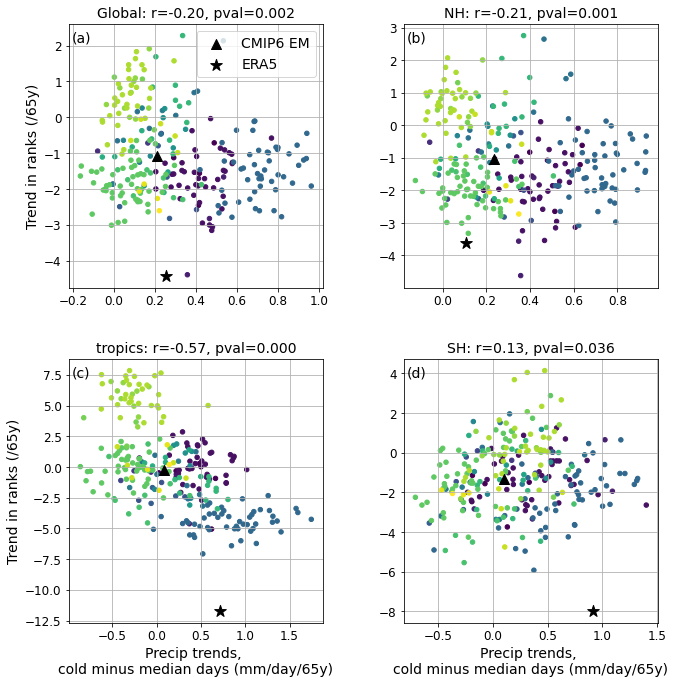

In [21]:
nregions = len(regions)
fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)#, sharex=True, sharey=True)
ax = ax.flatten()
fig.tight_layout(pad=5)
tail_metric_dict = {'cold': 'min', 'hot': 'max'}
edges = np.array([1, 1, 2, 1.5])

rvals = []
pvals = []

obs_ct = 0
letter_count = 0

if stat == 'trend':
    xlabel = 'Precip trends, \n%s minus median days (mm/day/%iy)' % (tail, trend_normalizer)
elif stat == 'avg_rain':
    xlabel = 'Average precip, \n%s minus median days (mm/day)' % (tail.capitalize())
elif stat == 'prob_rain':
    xlabel = 'Prob precip, %s minus median days' % (tail.capitalize())

for r_ct, region in enumerate(regions):
    delta_pr_trend = ds_all_cmip_precip.sel(region=region)
    rank_trend = beta_ranks_cmip.sel({'model-variant': delta_pr_trend.mv, 'region': region})
    
    # calculate EM
    em_trends_pr = []
    em_trends_rank = []
    le_vals = []
    le_names = []
    for ct_m, m in enumerate(models):
        this_model = np.isin(model_strs, m)
        em_trends_pr.append(delta_pr_trend.sel(mv=this_model).mean())
        em_trends_rank.append(rank_trend.sel(mv=this_model).mean())
        if np.sum(this_model) > 10:
            le_vals.append(delta_pr_trend.sel(mv=this_model).mean().data)
            le_names.append(m)
        
    EM_trend_pr = np.mean(np.array(em_trends_pr))
    EM_trend_rank = np.mean(np.array(em_trends_rank))
    print('++%s %s: ensemble mean is %0.2f' % (region, tail, EM_trend_pr))
    
    ax[r_ct].scatter(delta_pr_trend, rank_trend, s=20, color=color_vec)
    ax[r_ct].scatter(EM_trend_pr, EM_trend_rank, s=100, color='k', marker='^', zorder=5, label='CMIP6 EM')
    

    # Plot observations
    ax[r_ct].scatter(avg_pr_ERA5.sel(region=region), beta_ranks_ERA5.sel(region=region), 
                     s=150, color='k', marker='*', zorder=5, label='ERA5', edgecolors='k')
    
    print('Observed value is %0.2f' % avg_pr_ERA5.sel(region=region))
    print('Number of models with smaller trend: %i' % np.sum(delta_pr_trend < avg_pr_ERA5.sel(region=region)))
    
    rval, pval = stats.pearsonr(delta_pr_trend, rank_trend)
    ax[r_ct].set_title('%s: r=%0.2f, pval=%0.3f' % (region, rval, pval), fontsize=fontsize) 
    rvals.append(rval)
    pvals.append(pval)
    
    if r_ct > 1:
        ax[r_ct].set_xlabel(xlabel, fontsize=fontsize)
    
    if (r_ct % 2) == 0:
        ax[r_ct].set_ylabel('Trend in ranks (/%iy)' % trend_normalizer, fontsize=fontsize)
    
    ax[r_ct].tick_params(labelsize=labelsize)
    ax[r_ct].text(0.01, 0.93, '(%s)' % (letters[letter_count]), 
                transform=ax[r_ct].transAxes,
                fontsize=fontsize)
    if r_ct == 0:
        ax[r_ct].legend(fontsize=fontsize, loc='upper right')
    letter_count += 1
for a in ax:
    a.grid()
    
     
# Calculate significance
pcut = hu_stats.get_FDR_cutoff(xr.DataArray(pvals), alpha_fdr=alpha_fdr)
is_sig = pvals < pcut
for r_ct, region in enumerate(regions):
    print('%s: correlation=%0.2f, pval=%0.2f, sig=%s' % (region, rvals[r_ct], pvals[r_ct], is_sig[r_ct]))

plt.savefig('%s/SUPP_cmip_%s_precip_vs_ranks.png' % (figdir, stat), dpi=200, bbox_inches='tight')

# Maps of CMIP6 rank trends

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


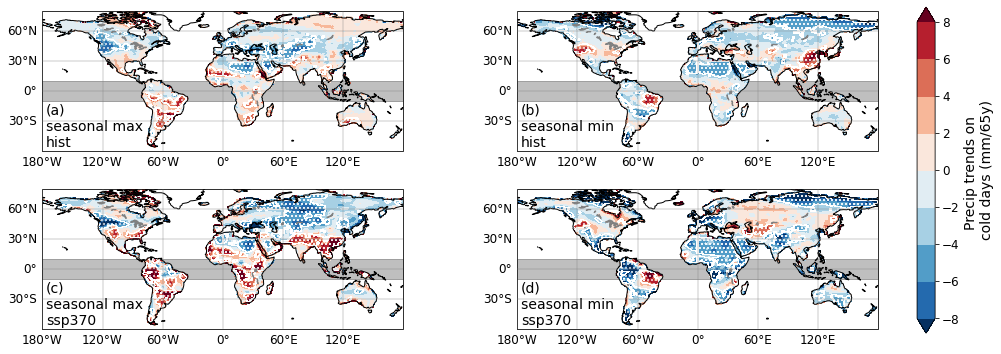

In [22]:
figname = 'SUPP_cmip_EM_ranks.png'

agree_cutoff = 2/3

fig = plt.figure(figsize=(16, 6))

widths = [1, 0.1, 1, 0.05]
heights = 2*np.ones(len(scenarios))
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.2, hspace=0.2)
cmap = plt.cm.RdBu_r
bounds = np.arange(-8, 9, 2)

letter_ct = 0

for p_ct, period in enumerate(scenarios):

    y1 = eval('%s_year1' % period)
    y2 = eval('%s_year2' % period)
    
    cmip_str = 'ranks_*_tasmax_years-%i-%i_warm-season_2x45-days_lat-60-80.nc' % (y1, y2)
    cmip_rank_files = sorted(glob('%s/%s' % (procdir, cmip_str)))
    
    savename = '%s/cmip_rank_maps_%s.nc' % (procdir, period)
    
    if os.path.isfile(savename):
        cmip_rank_maps = xr.open_dataset(savename)
    else:
    
        cmip_rank_maps = []
        names = []
        for f in cmip_rank_files:
            mv = f.split('/')[-1].split('_')[1]
            if mv == 'TaiESM1-r1i1p1f1':  # TaiESM1 is an outlier in ranks and precipitation
                continue
            names.append(mv)

            ds = xr.open_dataset(f)
            ds = swap_hot_ranks(ds)
            
            ds_beta_1x1 = xr.Dataset()
            for m in metrics_to_plot:
                beta = get_trend_array(ds, m, trend_normalizer)
                # regrid to 1x1
                regridder = xe.Regridder({'lat': beta.lat, 'lon': beta.lon},
                                         {'lat': is_land.lat.data, 'lon': is_land.lon.data},
                                         'bilinear',
                                         periodic=True, reuse_weights=False)

                beta_1x1 = regridder(beta)
                ds_beta_1x1[m] = beta_1x1

            cmip_rank_maps.append(ds_beta_1x1)
        
        cmip_rank_maps = xr.concat(cmip_rank_maps, dim='mv')
        cmip_rank_maps['mv'] = list(names)
        cmip_rank_maps.to_netcdf(savename)
    

    
    for m_ct, metric in enumerate(metrics_to_plot):
        
        to_plot = cmip_rank_maps[metric].mean('mv')
        do_agree1 = ((to_plot > 0) & (cmip_rank_maps[metric] > 0)).mean('mv')
        do_agree2 = ((to_plot < 0) & (cmip_rank_maps[metric] < 0)).mean('mv')

        do_agree = xr.apply_ufunc(np.maximum, do_agree1, do_agree2)

        ax_map = fig.add_subplot(spec[p_ct, 2*m_ct], projection=plotcrs)

        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds, is_sig=(do_agree > agree_cutoff))

        ax_map.set_title('')
        ax_map.text(0.01, 0.03, '(%s)\n%s\n%s' % (letters[letter_ct], metric.replace('_', ' '), period), 
                    transform=ax_map.transAxes, fontsize=fontsize)

        letter_ct += 1


cax = fig.add_subplot(spec[:, -1])
cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=labelsize) 
cb.set_label(cbar_label, fontsize=fontsize)

plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Maps of CMIP6 precipitation stats, on average

trend
avg_rain
prob_rain


/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


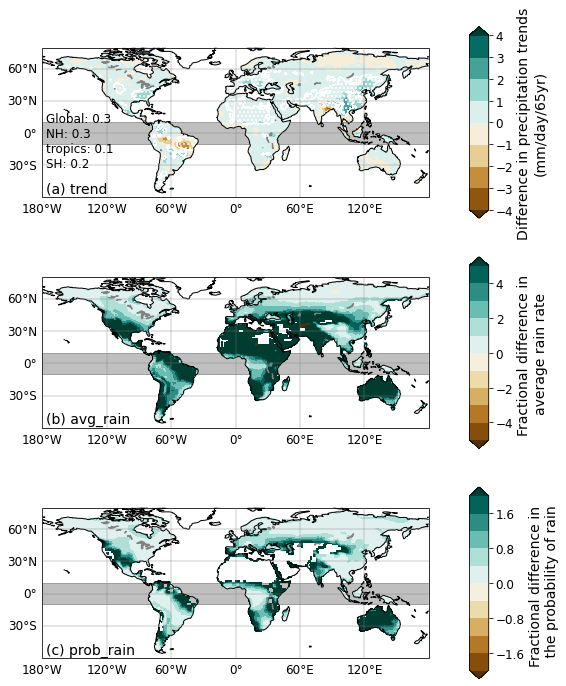

In [23]:
figname = 'SUPP_precip_stats_cmip.png'
agree_cutoff = 2/3
tail = 'cold'
fnames = sorted(glob('%s/*-*_precip_relative_stats_p%02i_%i-%i.nc' % (procdir, percentile_width, 
                                                                      hist_year1, hist_year2)))

fig = plt.figure(figsize=(8, 12))

widths = [1, 0.05]
heights = 2*np.ones(len(stat_opts))
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.2, hspace=0.2)
cmap = plt.cm.BrBG
letter_ct = 0

for ct_s, s in enumerate(stat_opts):
    print(s)
    savename = '%s/cmip_precip_%s_p%02i_%i-%i.nc' % (procdir, s, percentile_width, hist_year1, hist_year2)
    if os.path.isfile(savename):
        cmip_maps = xr.open_dataarray(savename)
    else:
    
        cmip_maps = []
        names = []
        for f in fnames:
            mv = f.split('/')[-1].split('_')[0]
            if mv == 'TaiESM1-r1i1p1f1':  # TaiESM1 is an outlier in ranks and precipitation
                continue
            names.append(mv)

            ds = xr.open_dataset(f)

            stat_tail = ds['%s_p%02i' % (s, tail_dict[tail])] 
            stat_median = ds['%s_p50' % s]

            if s == 'trend':
                delta = stat_tail - stat_median
            else:
                delta = (stat_tail - stat_median)/stat_median

            if 'type' in delta.coords:
                delta = delta.reset_coords('type', drop=True)
                

            # regrid to 1x1
            regridder = xe.Regridder({'lat': delta.lat, 'lon': delta.lon},
                                     {'lat': is_land.lat.data, 'lon': is_land.lon.data},
                                     'bilinear',
                                     periodic=True, reuse_weights=False)

            delta_1x1 = regridder(delta)
            del delta
            cmip_maps.append(delta_1x1)
            
        cmip_maps = xr.concat(cmip_maps, dim='mv')
        cmip_maps['mv'] = list(names)
        cmip_maps.to_netcdf(savename)
    
    to_plot = cmip_maps.mean('mv')
    do_agree1 = ((to_plot > 0) & (cmip_maps > 0)).mean('mv')
    do_agree2 = ((to_plot < 0) & (cmip_maps < 0)).mean('mv')

    do_agree = xr.apply_ufunc(np.maximum, do_agree1, do_agree2)
    
    if s == 'trend':
        cbar_label = 'Difference in precipitation trends\n(mm/day/%iyr)' % trend_normalizer
        bounds = np.arange(-4, 5, 1)

    elif s == 'avg_rain':
        cbar_label = 'Fractional difference in \naverage rain rate'
        bounds = 5*np.arange(-1, 1.1, 0.2)
      
    elif s == 'prob_rain':
        cbar_label = 'Fractional difference in \n the probability of rain'
        bounds = 2*np.arange(-1, 1.1, 0.2)

    ax_map = fig.add_subplot(spec[ct_s, 0], projection=plotcrs)

    if s == 'trend':
        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds, is_sig=(do_agree > agree_cutoff))
    else:
        ax_map, pc = make_standard_map(to_plot, ax_map, cmap, bounds)
    ax_map.set_title('')
    ax_map.text(0.01, 0.03, '(%s) %s' % (letters[letter_ct], s), 
                transform=ax_map.transAxes, fontsize=fontsize)

    letter_ct += 1

    # Get average values for each region to put on map
    if s == 'trend':
        ax_map = add_text_regional_averages(to_plot, ax_map, regions)


    cax = fig.add_subplot(spec[ct_s, -1])
    cb = plt.colorbar(pc, cax=cax, orientation='vertical', extend='both')
    cb.ax.tick_params(labelsize=labelsize) 
    cb.set_label(cbar_label, fontsize=fontsize)

plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Trends with varying start and end dates

Global, seasonal_max
For starting dates from 1980 onwards, 8.0 perc of trends are positive
NH, seasonal_max
For starting dates from 1980 onwards, 4.0 perc of trends are positive
tropics, seasonal_max
For starting dates from 1980 onwards, 49.7 perc of trends are positive
SH, seasonal_max
For starting dates from 1980 onwards, 70.7 perc of trends are positive
Global, seasonal_min
For starting dates from 1980 onwards, 1.3 perc of trends are positive
NH, seasonal_min
For starting dates from 1980 onwards, 2.0 perc of trends are positive
tropics, seasonal_min
For starting dates from 1980 onwards, 0.0 perc of trends are positive
SH, seasonal_min
For starting dates from 1980 onwards, 4.0 perc of trends are positive


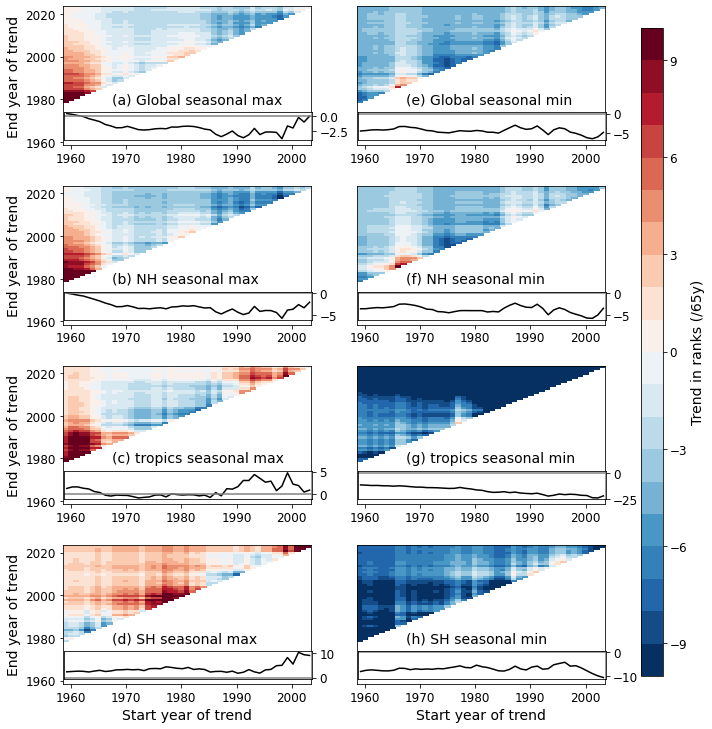

In [24]:
figname = 'SUPP_trend_start_end.png'


years = ds_ranks_ERA5.year
min_trend_length = 20

fig, axes = plt.subplots(figsize=(10, 10), nrows=4, ncols=2)
fig.tight_layout(w_pad=2.5, h_pad=2)
letter_ct = 0

cmap = plt.cm.RdBu_r
levels = np.arange(-10, 11)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
letter_ct = 0

for m_ct, metric in enumerate(metrics_to_plot):
    avg_vals = calc_regional_averages(ds_ranks_ERA5[metric], regions)

    for r_ct, region in enumerate(regions):

        ax = axes[r_ct, m_ct]
        years_start = years[:-min_trend_length]
        
        trend_mat = np.nan*np.ones((len(years_start), len(years)))
        for ct1, y1 in enumerate(years_start):  # starting year
            for ct2, y2 in enumerate(years):  # ending year
                if y2 < (y1 + min_trend_length):
                    continue
                this_ts = avg_vals.sel(region=region).copy().sel(year=slice(y1, y2))
                X = this_ts.year.data.astype(float)
                X -= np.mean(X)
                linfit = stats.linregress(X, this_ts)
                trend_mat[ct1, ct2] = trend_normalizer*linfit.slope
                
        im = ax.pcolormesh(years_start, years, trend_mat.T, cmap=cmap, norm=norm, shading='auto')
        
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes

        # Define the position and size of the inset axis
        # [x0, y0, width, height] - all values are relative to the main axis
        inset_ax = inset_axes(ax, width="100%", height="40%", loc='lower left', 
                              bbox_to_anchor=(-0.015, 0.0, 1, 0.5), bbox_transform=ax.transAxes)

        # Plot the second dataset on the inset axis
        inset_ax.plot(years_start, trend_mat[:, -1], color='k')
        inset_ax.yaxis.tick_right()
        
        #inset_ax.spines['top'].set_visible(False)
        # ax.spines['right'].set_visible(False)
        #inset_ax.spines['bottom'].set_visible(False)
        #inset_ax.spines['left'].set_visible(False)

        # Hide the x-axis of the inset axis
        inset_ax.get_xaxis().set_visible(False)
        inset_ax.patch.set_alpha(0.5)
        inset_ax.set_xlim(ax.get_xlim())
        inset_ax.axhline(0, color='gray')
        inset_ax.tick_params(labelsize=labelsize)
  
        
        # For satellite era analysis, print out fraction of trends with positive trend after 1980
        trend_vec = trend_mat[years_start >= 1980, :].flatten()
        trend_vec = trend_vec[~np.isnan(trend_vec)]
        percent_positive = np.mean(trend_vec > 0)
        print('%s, %s' % (region, metric))
        print('For starting dates from 1980 onwards, %0.1f perc of trends are positive' % 
              (100*percent_positive))
        
        if r_ct == 3:
            ax.set_xlabel('Start year of trend', fontsize=fontsize)
        else:
            ax.set_xlabel('')
        if m_ct == 0:
            ax.set_ylabel('End year of trend', fontsize=fontsize)
        else:
            ax.set_ylabel('')
            ax.set_yticks([])
        ax.tick_params(labelsize=labelsize)
        ax.text(0.2, 0.3, '(%s) %s %s' % (letters[letter_ct], region, metric.replace('_', ' ')),
                transform=ax.transAxes, fontsize=fontsize)
        letter_ct += 1
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.05, 0.03, 0.9])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=labelsize) 
cb.set_label('Trend in ranks (/%iy)' % trend_normalizer, fontsize=fontsize)
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Example of weird ERA5 data

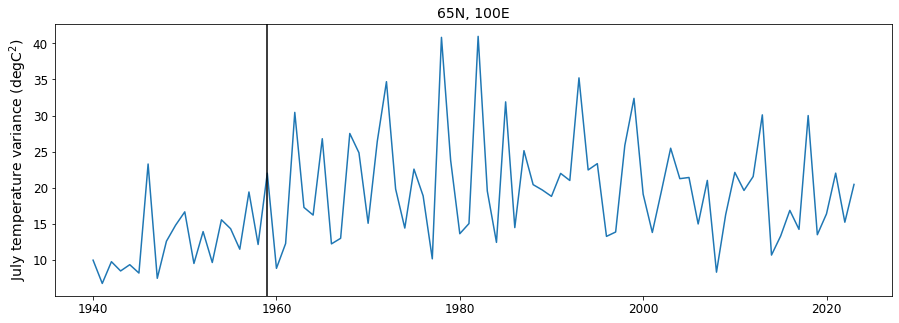

In [25]:
figname = 'SUPP_bad_ERA5_example.png'

this_lat = 65
this_lon = 100
savename = '%s/bad_data_%iN-%iE.nc' % (procdir, this_lat, this_lon)
if os.path.isfile(savename):
    this_ts = xr.open_dataarray(savename)
else:
    t_data_dir = '/home/data/ERA5/day'
    tvar = 't2m_x'

    files = sorted(glob('%s/%s/1x1/%s_????_1x1.nc' % (t_data_dir, tvar, tvar)))

    da = xr.open_mfdataset(files, chunks={'time': -1, 'lat': 1, 'lon': 1})[tvar]

    this_ts = da.sel(lat=this_lat, lon=this_lon, method='nearest').load()

    this_ts.to_netcdf(savename)

fig, ax = plt.subplots(figsize=(15, 5))
this_ts.sel(time=this_ts['time.month']==7).groupby('time.year').var().plot(ax=ax)
ax.axvline(1959, color='k')
ax.set_title('%iN, %iE' % (this_lat, this_lon), fontsize=fontsize)
ax.tick_params(labelsize=labelsize)
ax.set_xlabel('')
ax.set_ylabel('July temperature variance (degC$^2$)', fontsize=fontsize)
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Synthetic data example

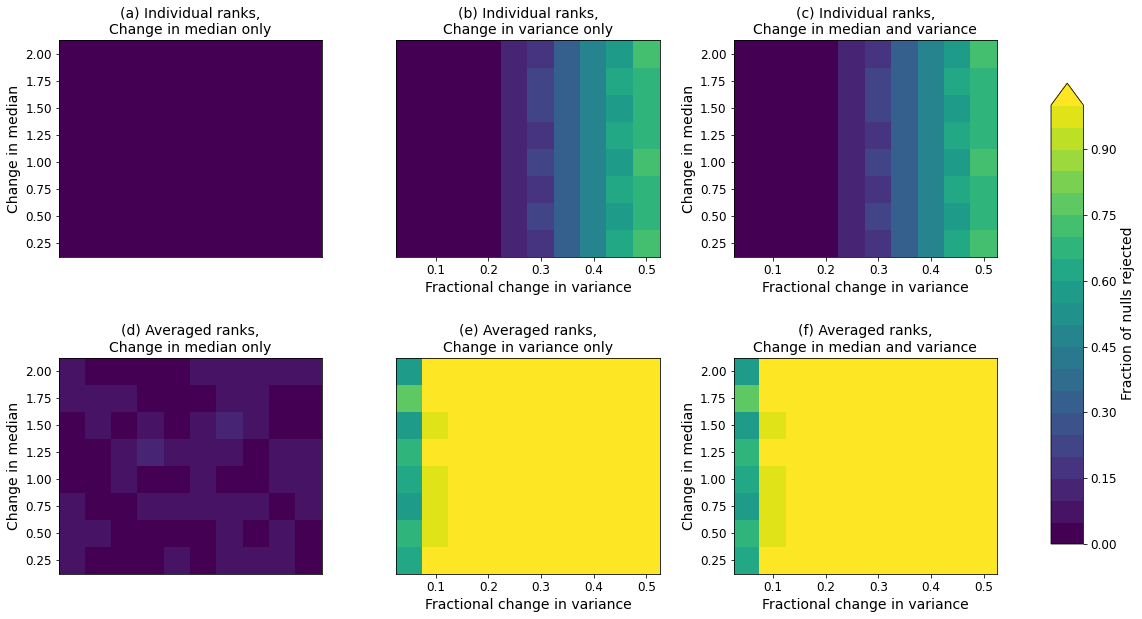

In [26]:
figname = 'SUPP_synthetic_data.png'

da_sig_indiv = xr.open_dataarray('%s/synthetic_indiv.nc' % procdir)
da_sig_avg = xr.open_dataarray('%s/synthetic_avg.nc' % procdir)
cases = list(('mean_only', 'var_only', 'mean_var'))
long_names = 'Change in median only', 'Change in variance only', 'Change in median and variance'

fig, ax = plt.subplots(figsize=(15, 8), nrows=2, ncols=3)#, sharex=True, sharey=True)
fig.tight_layout(h_pad=8, w_pad=5)
cmap = plt.cm.viridis
bounds = np.arange(0, 1.01, 0.05)
letter_ct = 0
for ct, case in enumerate(cases):
        

    da_sig_indiv.mean('sample').sel(case=case).plot(ax=ax[0, ct], cmap=cmap, 
                                                    levels=bounds, extend='max', add_colorbar=False)
    im = da_sig_avg.mean('sample').sel(case=case).plot(ax=ax[1, ct], cmap=cmap, 
                                                  levels=bounds, extend='max', add_colorbar=False)

    
    if (case == 'var_only') | (case == 'mean_var'):
        ax[1, ct].set_xlabel('Fractional change in variance', fontsize=fontsize)
        ax[0, ct].set_xlabel('Fractional change in variance', fontsize=fontsize)
    else:
        ax[1, ct].set_xlabel('')
        ax[0, ct].set_xlabel('')
        ax[1, ct].set_xticks([])
        ax[0, ct].set_xticks([])
    if (case == 'mean_only') | (case == 'mean_var'):
        ax[1, ct].set_ylabel('Change in median', fontsize=fontsize)
        ax[0, ct].set_ylabel('Change in median', fontsize=fontsize)
    else:
        ax[1, ct].set_ylabel('')
        ax[0, ct].set_ylabel('')
        ax[1, ct].set_yticks([])
        ax[0, ct].set_yticks([])
    
        
    ax[0, ct].set_title('(%s) Individual ranks,\n%s' % (letters[letter_ct], long_names[ct]), 
                        fontsize=fontsize)
    ax[1, ct].set_title('(%s) Averaged ranks,\n%s' % (letters[letter_ct + 3], long_names[ct]), 
                        fontsize=fontsize)
    letter_ct += 1

for a in ax.flatten():
    a.tick_params(labelsize=labelsize)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=labelsize) 
cb.set_label('Fraction of nulls rejected', fontsize=fontsize)
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')
    

# Comparison of seasonality to the mean for SEB model

/home/kmckinnon/stats_kam/lib/python3.9/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


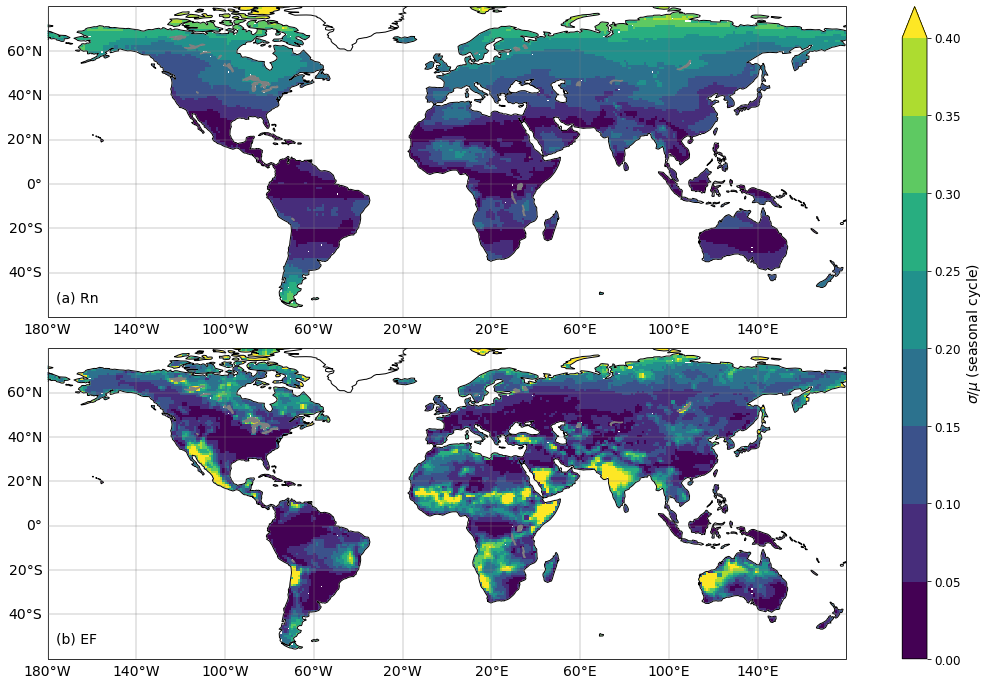

In [27]:
figname = 'SUPP_sigma_to_mu_seasonal_cycle.png'

ds_clim = xr.open_dataset('%s/SEB_clims_1958-2023.nc' % procdir)

Rn = ds_clim['surface_net_solar_radiation'] - ds_clim['surface_net_thermal_radiation']
EF = ds_clim['evaporative_fraction']

# Subset to warm season
da_doy = xr.open_dataarray('%s/ERA5_hottest_doys_%s.nc' % (procdir, 't2m_x'))   
Rn = Rn.where(da_doy == 1)
EF = EF.where(da_doy == 1)

fig = plt.figure(figsize=(16, 12))
spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 0.03], height_ratios=[1, 1])

spec.update(wspace=0.1, hspace=0.1)

bounds = np.arange(0, 0.41, 0.05)
cmap = plt.cm.viridis

var_opts = 'Rn', 'EF'
for ct, this_var in enumerate(var_opts):
    this_ds = eval('%s' % this_var)
    sigma_to_mu = this_ds.std('dayofyear')/this_ds.mean('dayofyear')


    cbar_label = r'$\sigma$/$\mu$ (seasonal cycle)'

    norm = colors.BoundaryNorm(bounds, cmap.N)
    ax_map = fig.add_subplot(spec[ct, 0], projection=plotcrs)

    sc = sigma_to_mu.plot.pcolormesh(ax=ax_map,
                                 cmap=cmap,
                                 levels=bounds,
                                 transform=datacrs,
                                 zorder=1,
                                 add_colorbar=False)

    ax_map.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax_map.add_feature(cfeature.COASTLINE, color='black', zorder=2)
    ax_map.add_feature(cfeature.LAKES, color='gray', zorder=2)

    gl = ax_map.gridlines(crs=ccrs.PlateCarree(), linewidth=2, 
                      color='gray', alpha=0.2, linestyle='-', draw_labels=True, zorder=3)
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 40))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 80, 20))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'black', 'fontsize': fontsize}
    gl.ylabel_style = {'color': 'black', 'fontsize': fontsize}
    ax_map.set_title('')
    ax_map.text(0.01, 0.05, '(%s) %s' % (letters[ct], this_var), transform=ax_map.transAxes,
                fontsize=fontsize)

cax = fig.add_subplot(spec[:, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='max')
cb.ax.tick_params(labelsize=labelsize) 
cb.set_label(cbar_label, fontsize=fontsize)

plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')

# Distribution of trends with different skewnesses

In [ ]:
figname = 'SUPP_skew_trends.png'
np.random.seed(1)
ndays_per_summer = 91
nyears = 65
nloc = 50

fname = '%s/ERA5_warm_season_skew.nc' % procdir
skew_da = xr.open_dataarray(fname)
skew_opts = skew_da.data.flatten()
has_data = ~np.isnan(skew_opts)
skew_opts = skew_opts[has_data]

# for demonstration, choose relatively extreme skew values
percentiles = 100 - np.logspace(0, 2, nloc + 1)
skew_choice = np.percentile(skew_opts, percentiles)

Ntest = 10000
beta = np.empty((Ntest, ))
p = np.empty((Ntest, ))
for kk in range(Ntest):
    metric = get_metric(nyears, ndays_per_summer, skew_choice)
    beta[kk], p[kk] = get_metric_slope_p(metric)
    
# Test normal behavior
beta_n = np.empty((Ntest, ))
p_n = np.empty((Ntest, ))
for kk in range(Ntest):
    metric = get_metric(nyears, ndays_per_summer, skew_choice, normal=True)
    beta_n[kk], p_n[kk] = get_metric_slope_p(metric)

fig, ax = plt.subplots(figsize=(8, 5))
_, bins, _ = ax.hist(nyears*beta, bins=30, density=True, lw=4, label='Sampled skews')
ax.hist(nyears*beta_n, bins=bins, density=True, lw=4, alpha=0.5, color='tab:green', label='Normal')
ax.set_yscale('log')
ax.tick_params(labelsize=labelsize) 
ax.set_xlabel('Trend in width ($^\circ$C/%iy)' % nyears, fontsize=14)
ax.set_ylabel('Log pdf', fontsize=14)
ax.legend(fontsize=fontsize)
plt.savefig('%s/%s' % (figdir, figname), dpi=200, bbox_inches='tight')